Given data about heating, a new data frame was created with how long heating was turned on in past hour. With that, outside temperature, setpoint, rain sensor and current temperature, regression model that predicts future temperature was created. This model predicts temperature in next minute but it is possible to predict future temperature for longer by feeding predicted temperature back to itself for several iterations.

This model made it possible to create new boolean data frame by predicting temperature in next 3 hours for every data point with few catches:

    - heating will be on for next minute, and off beyond that
    - every other variable won't change

This boolean data frame is used as target values to create classification model that predicts if temperature will rise beyond setpoint in next 3 hours.

In [1]:
import os
import time
from multiprocessing import Process, Queue, cpu_count
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, plot_roc_curve, f1_score, accuracy_score
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = None
pd.options.display.max_columns = None
seperator = ","
kernel_start = time.time()

In [2]:
def load_data() -> list:
    """Loads all data from csv into list of data frames."""
    start = pd.to_datetime("2020-09-27T00:00:00")
    end = pd.to_datetime("2021-01-21T00:00:00")
    frames = []
    for filename in sorted(os.listdir("./data")):
        new_df = pd.read_csv(f"./data/{filename}", sep=seperator)
        new_df["time"] = pd.to_datetime(new_df["time"]).dt.round("s")
        new_df = new_df[(new_df["time"] >= start) & (new_df["time"] < end)]
        new_df = new_df.set_index("time")
        name = new_df["name"][0]
        new_df = new_df.rename(columns = {"value": name})
        new_df = new_df.drop(columns="name")
        frames.append(new_df)
    return frames

In [3]:
frames = load_data()

In [4]:
for frame in frames:
    print(frame.isnull().sum())

Centralne_BlokadaOgrzewania    0
dtype: int64
CisnienieAtmosferyczne    0
dtype: int64
EGardenCzujnikDeszczu    0
dtype: int64
Grzejnik_BlokadaKotlaCO    0
dtype: int64
Grzejnik_Gabinet    0
dtype: int64
Grzejnik_Glowna_Sypialnia    0
dtype: int64
Grzejnik_LazienkaGorna_Podlogowka    0
dtype: int64
Grzejnik_Parter_Podlogowka    0
dtype: int64
Grzejnik_Salon    0
dtype: int64
Grzejnik_Sypialnia    0
dtype: int64
Setpoint_Gabinet    0
dtype: int64
Setpoint_GlownaSypialnia    0
dtype: int64
Setpoint_Hol    0
dtype: int64
Setpoint_LazienkaGorna    0
dtype: int64
Setpoint_Salon    0
dtype: int64
Setpoint_Sypialnia    0
dtype: int64
TemperaturaZewnetrzna    0
dtype: int64
Temperatura_Gabinet    0
dtype: int64
Temperatura_GlownaSypialnia    0
dtype: int64
Temperatura_Hol    0
dtype: int64
Temperatura_LazienkaGorna    0
dtype: int64
Temperatura_Salon    0
dtype: int64
Temperatura_Sypialnia    0
dtype: int64
Tryb_Gabinet    0
dtype: int64
Tryb_GlownaSypialnia    0
dtype: int64
Tryb_Hol    0
dty

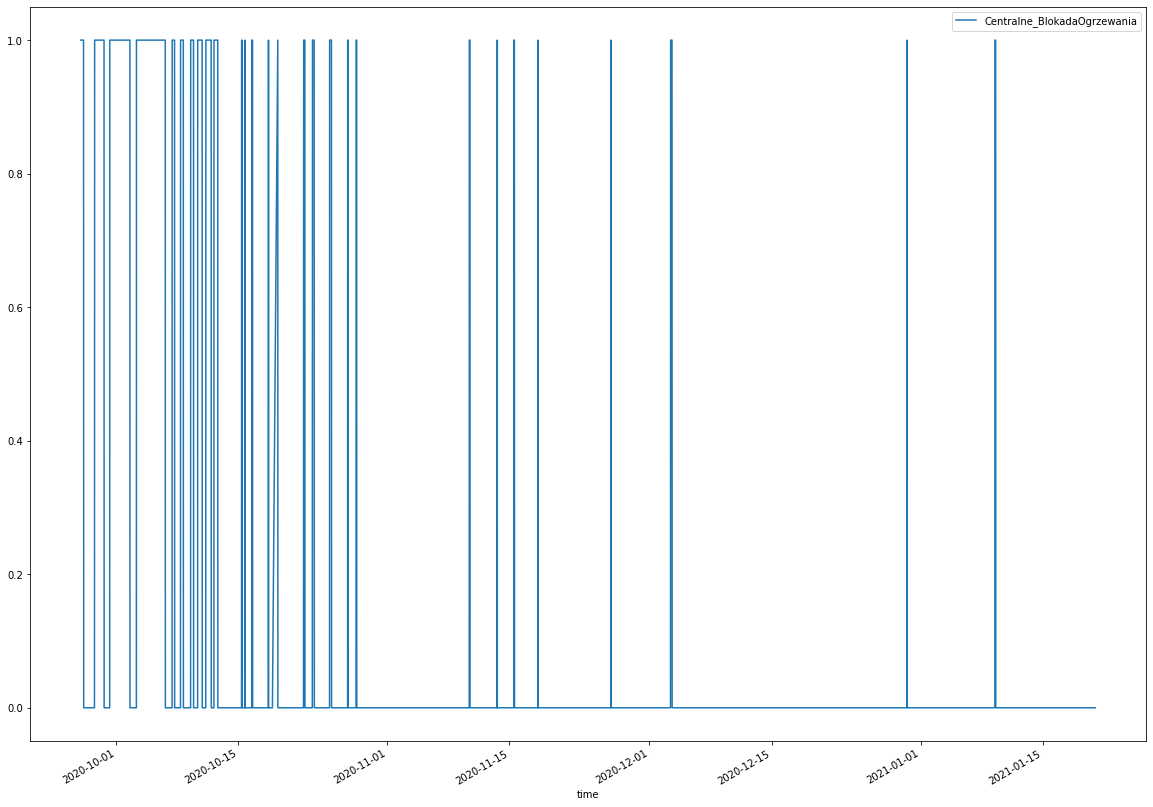

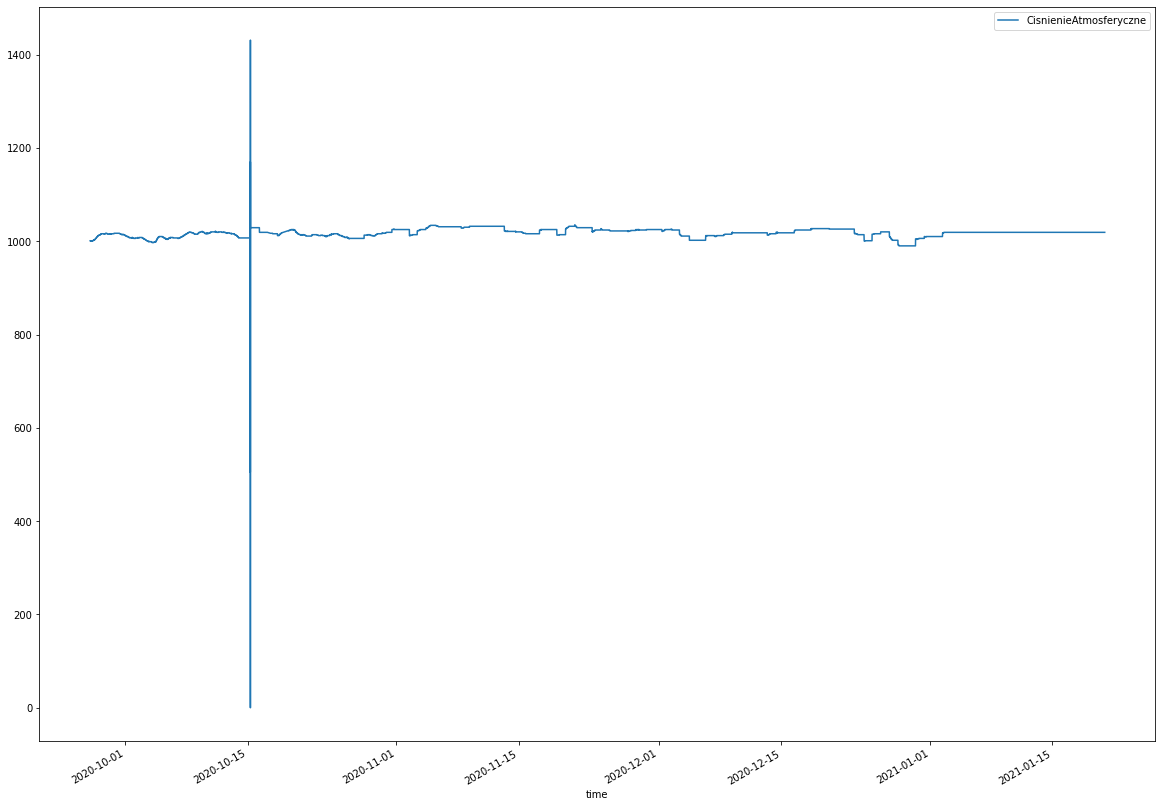

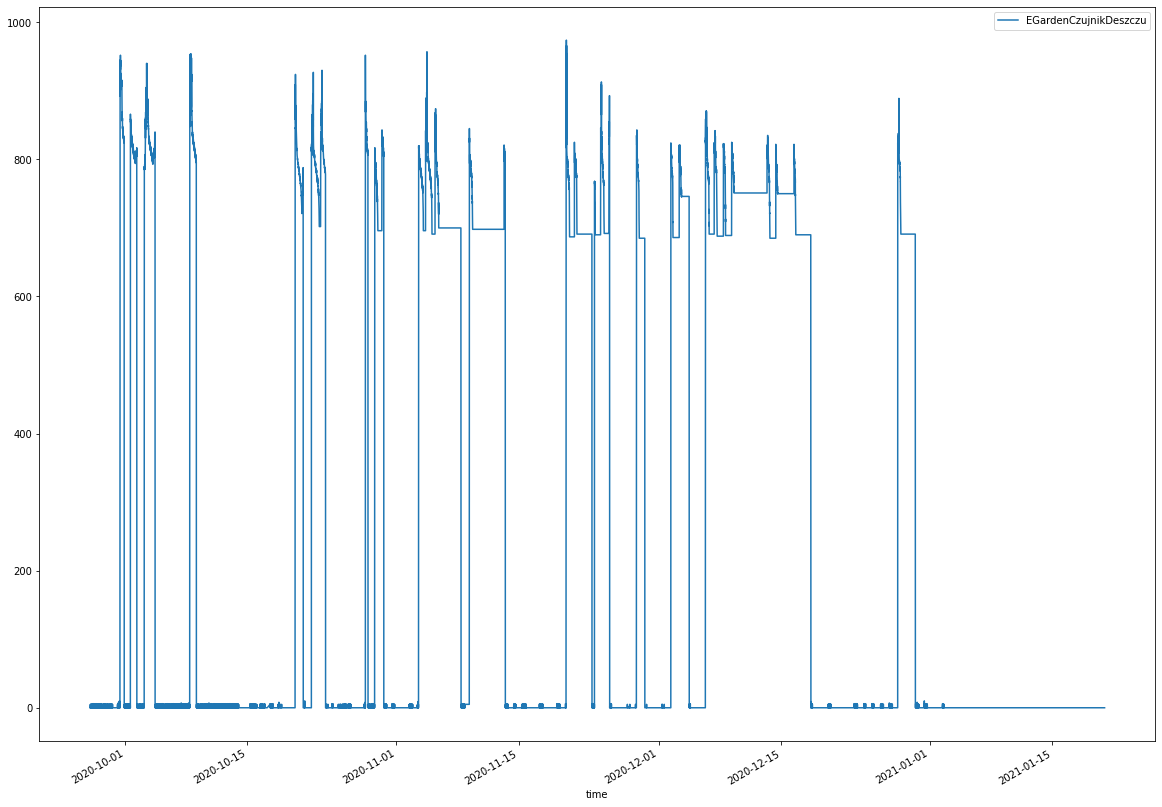

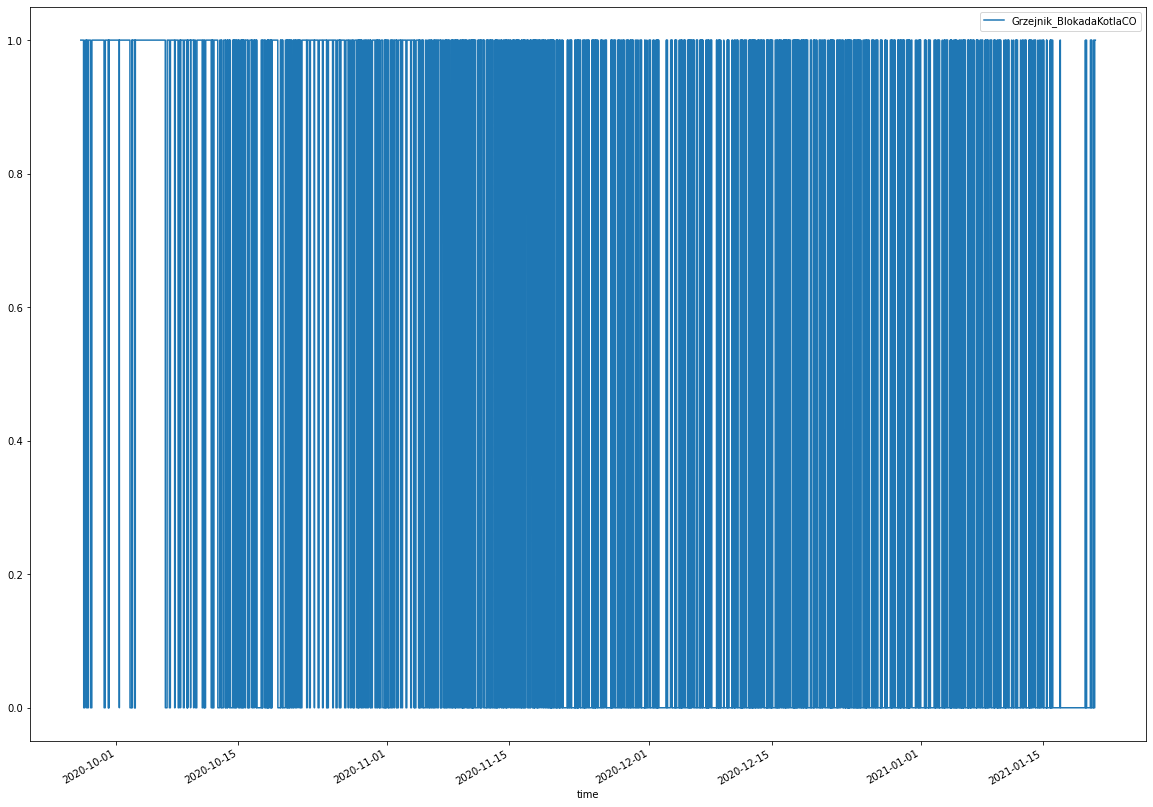

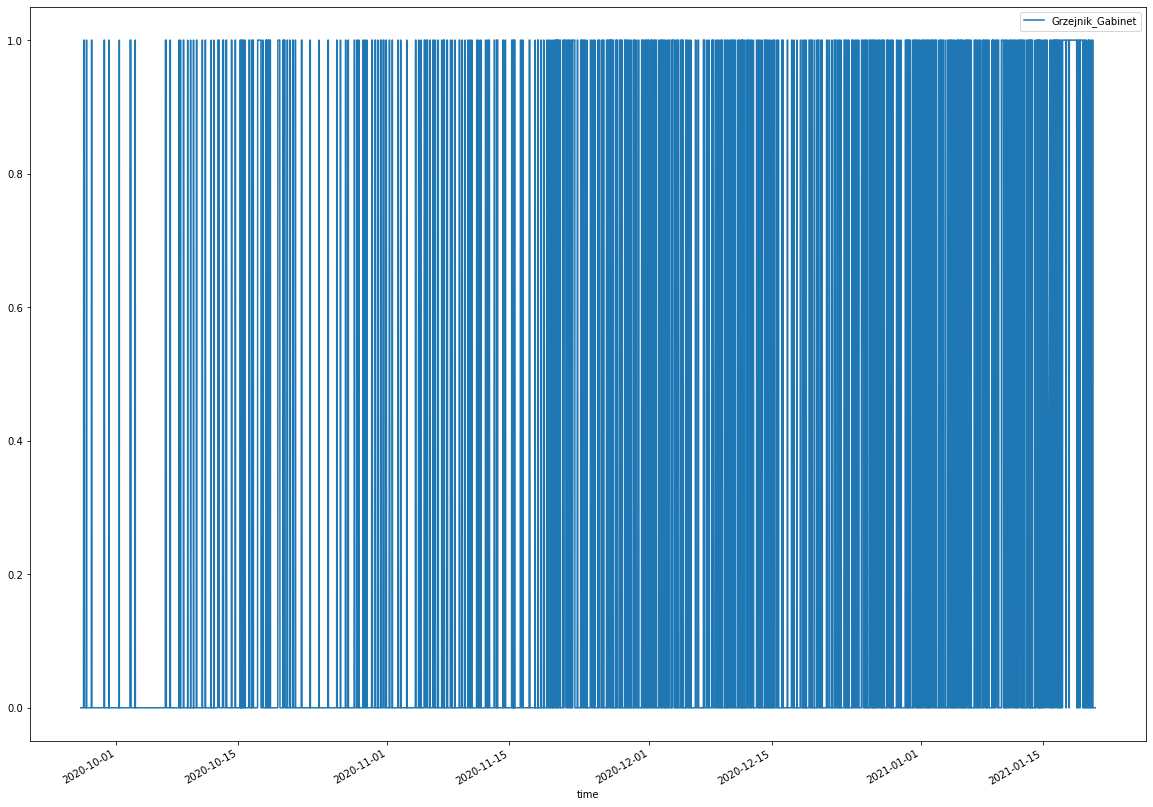

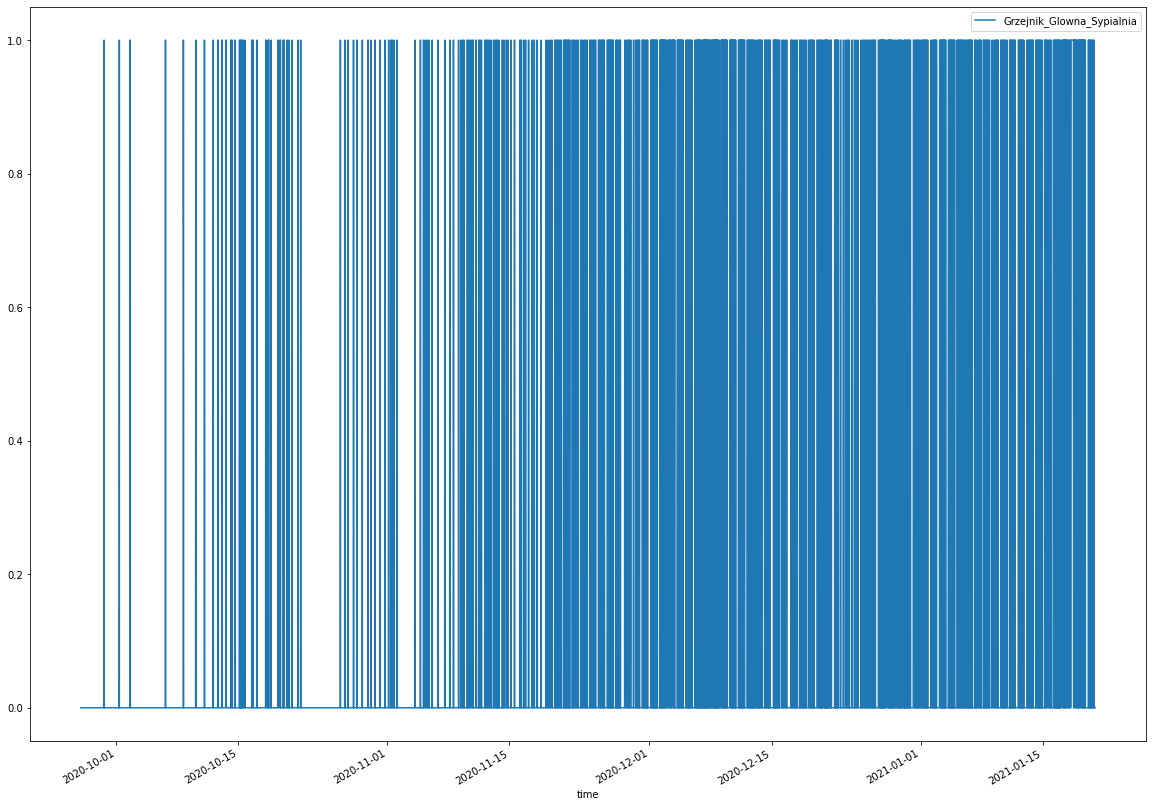

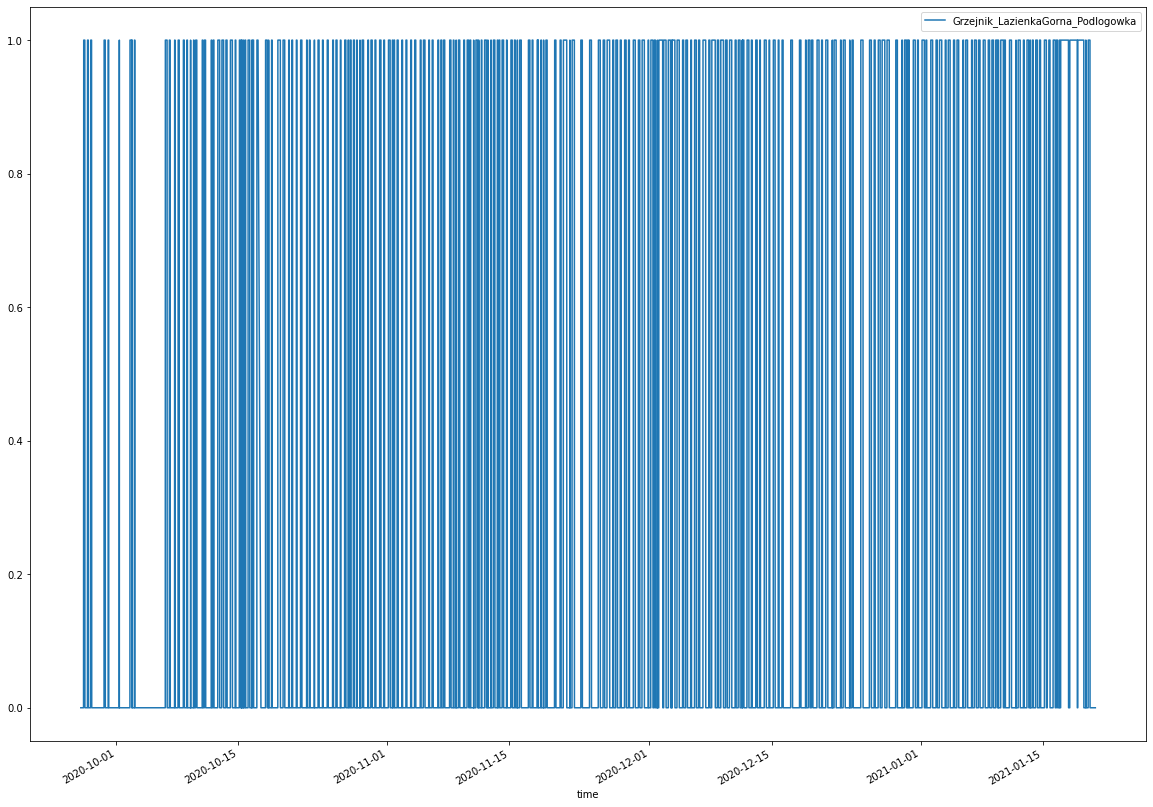

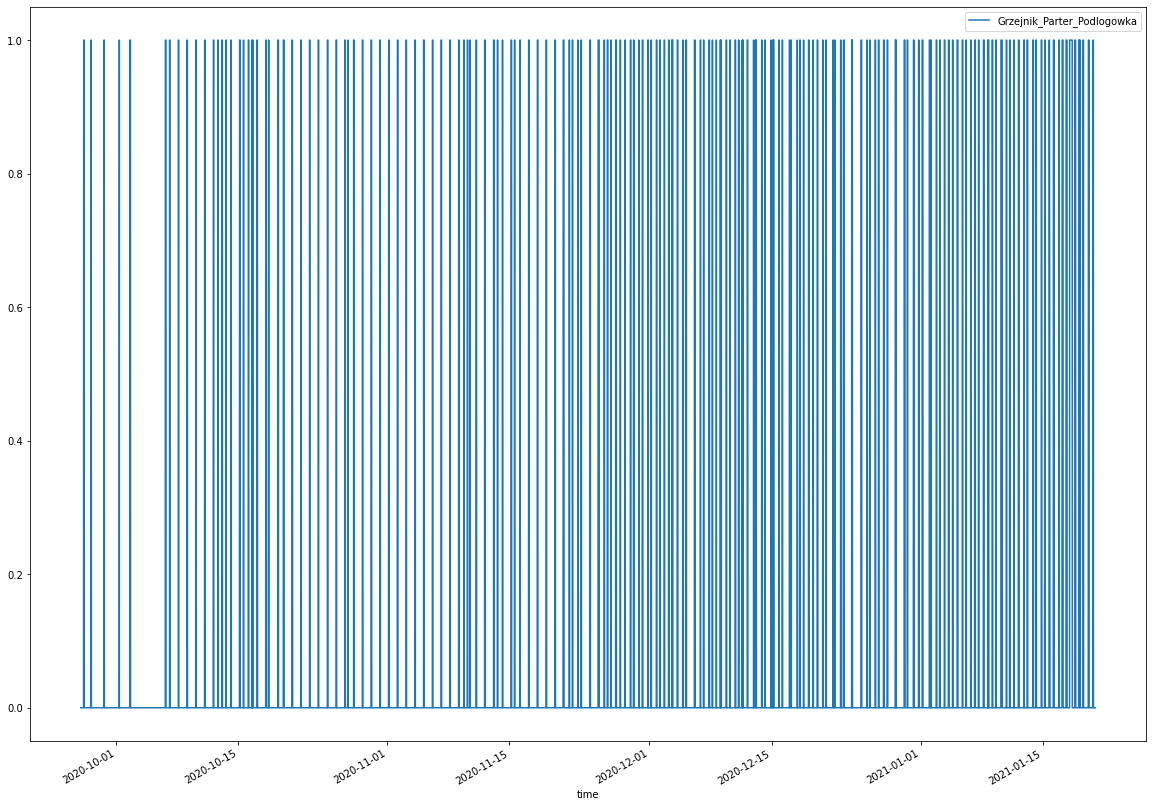

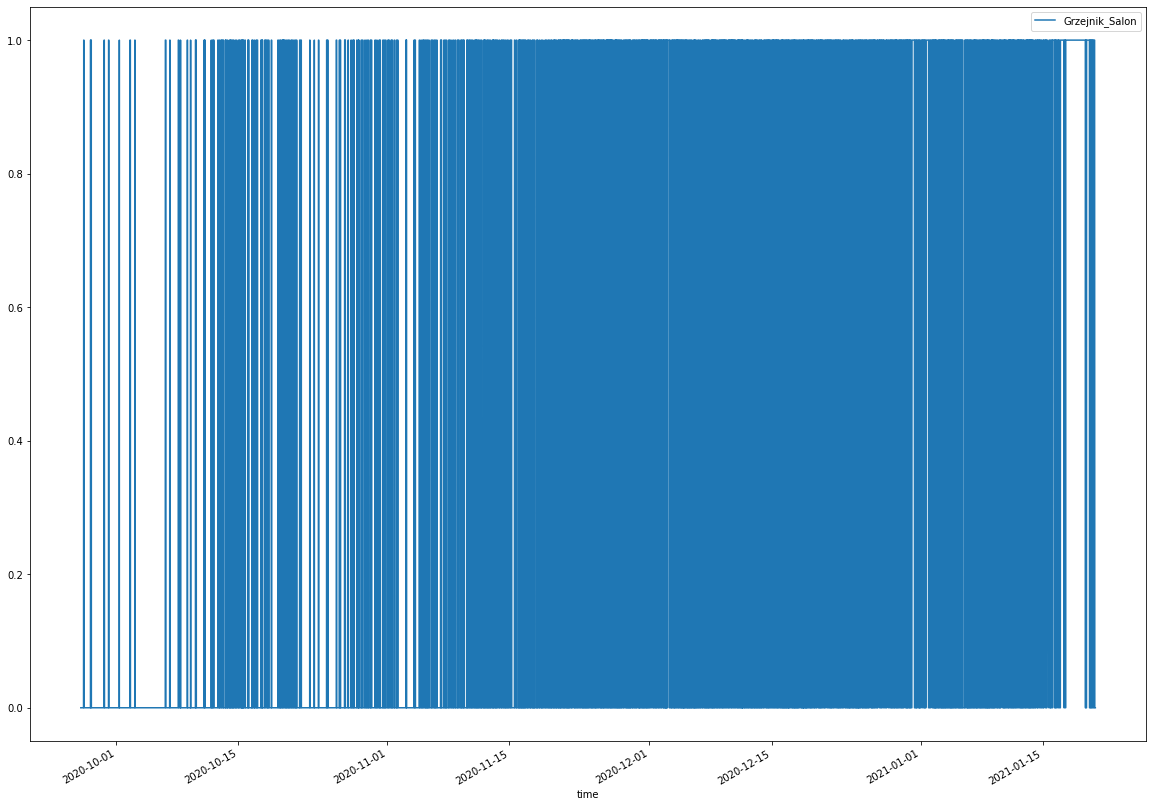

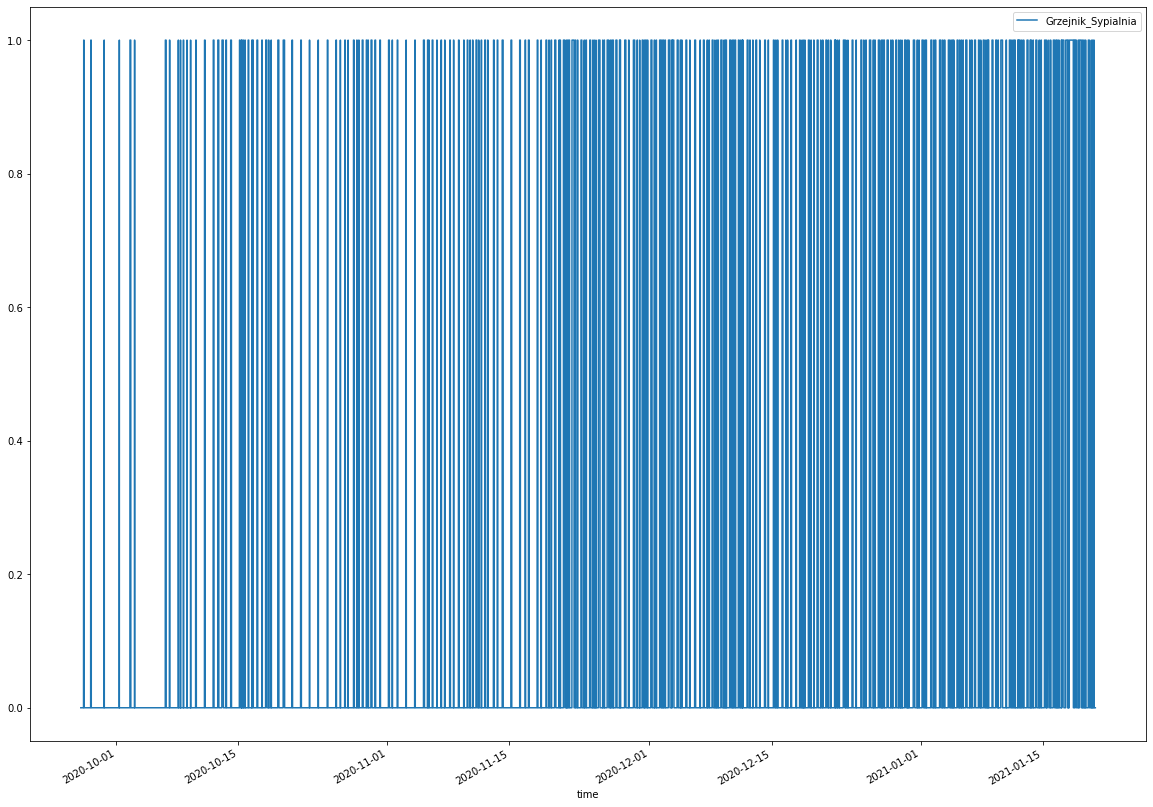

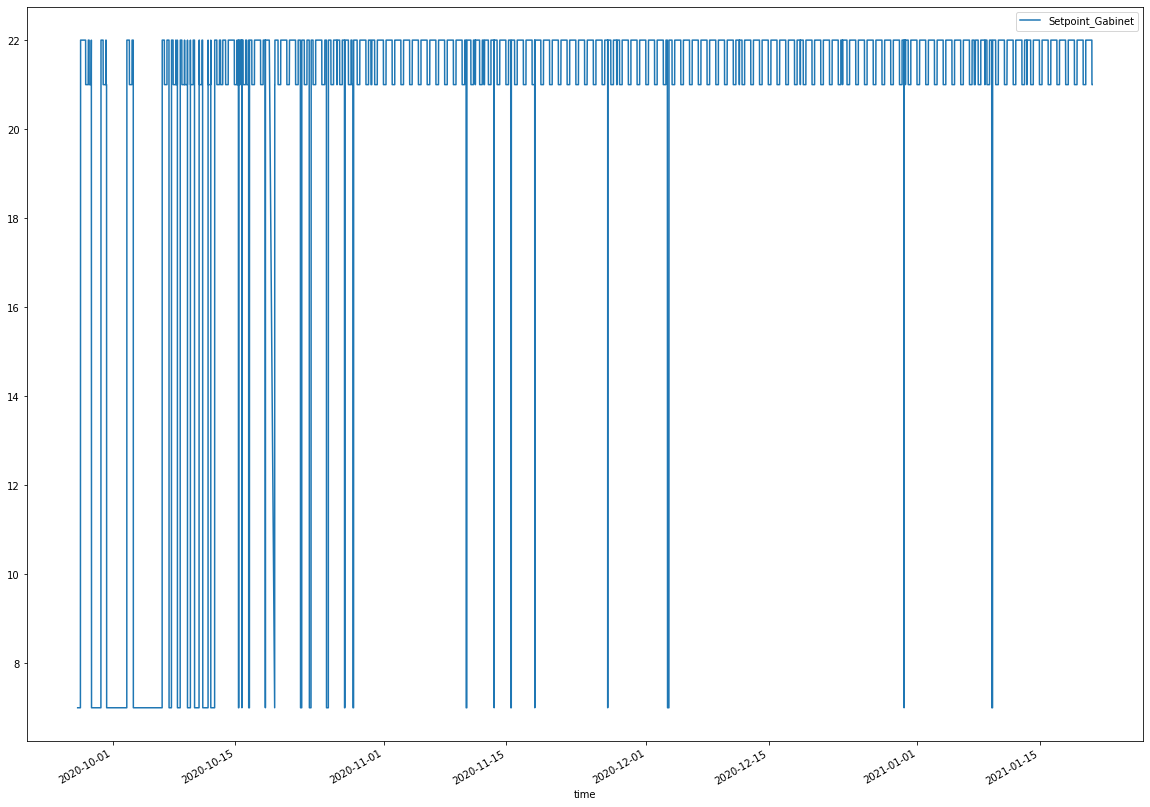

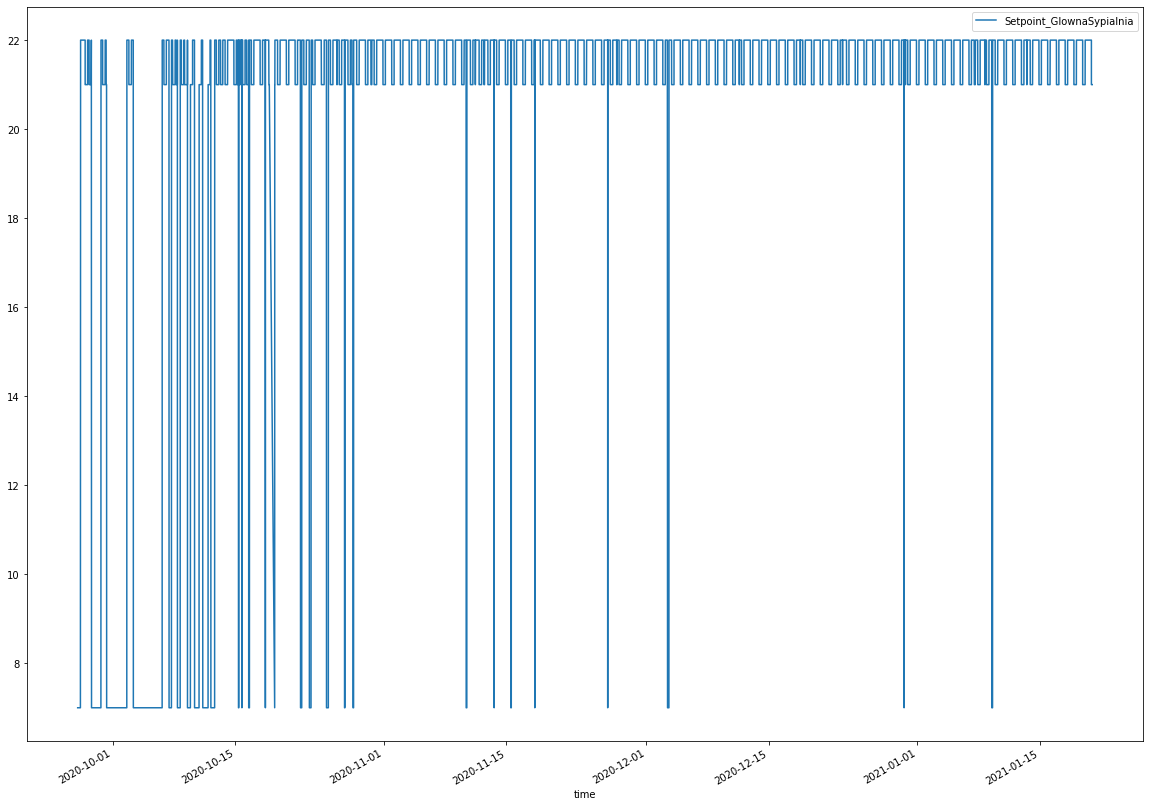

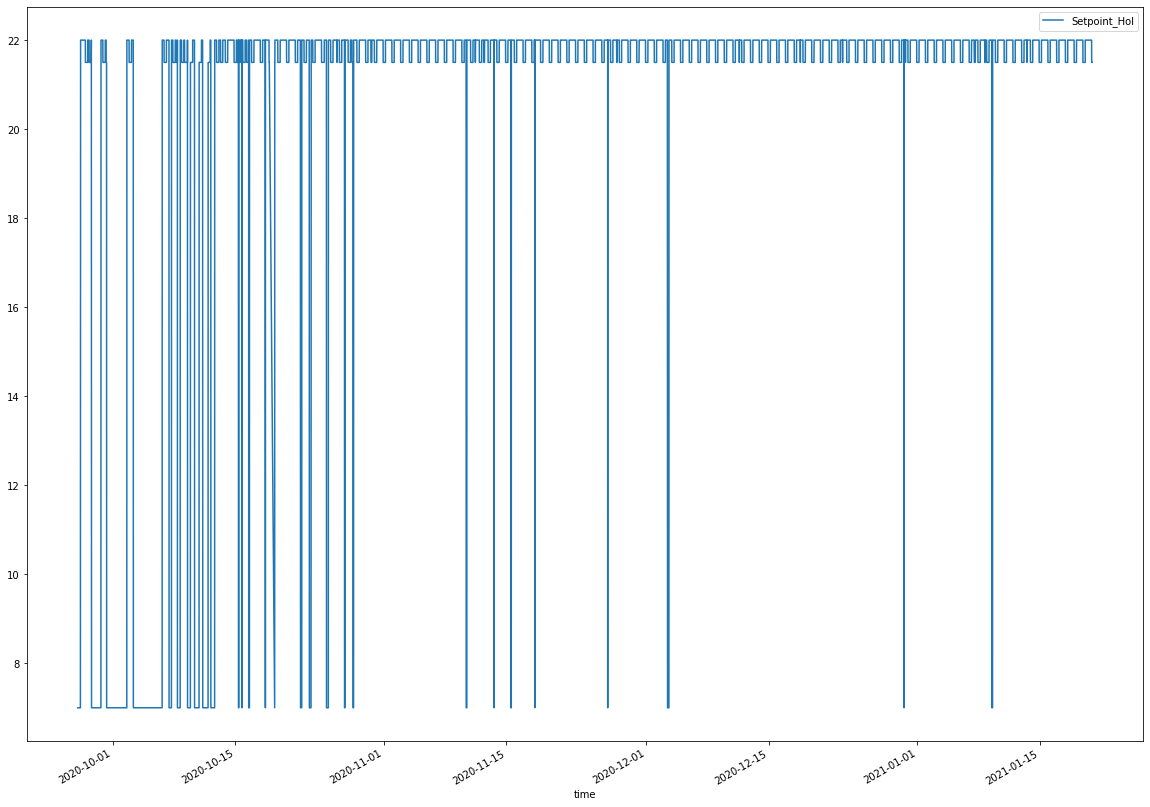

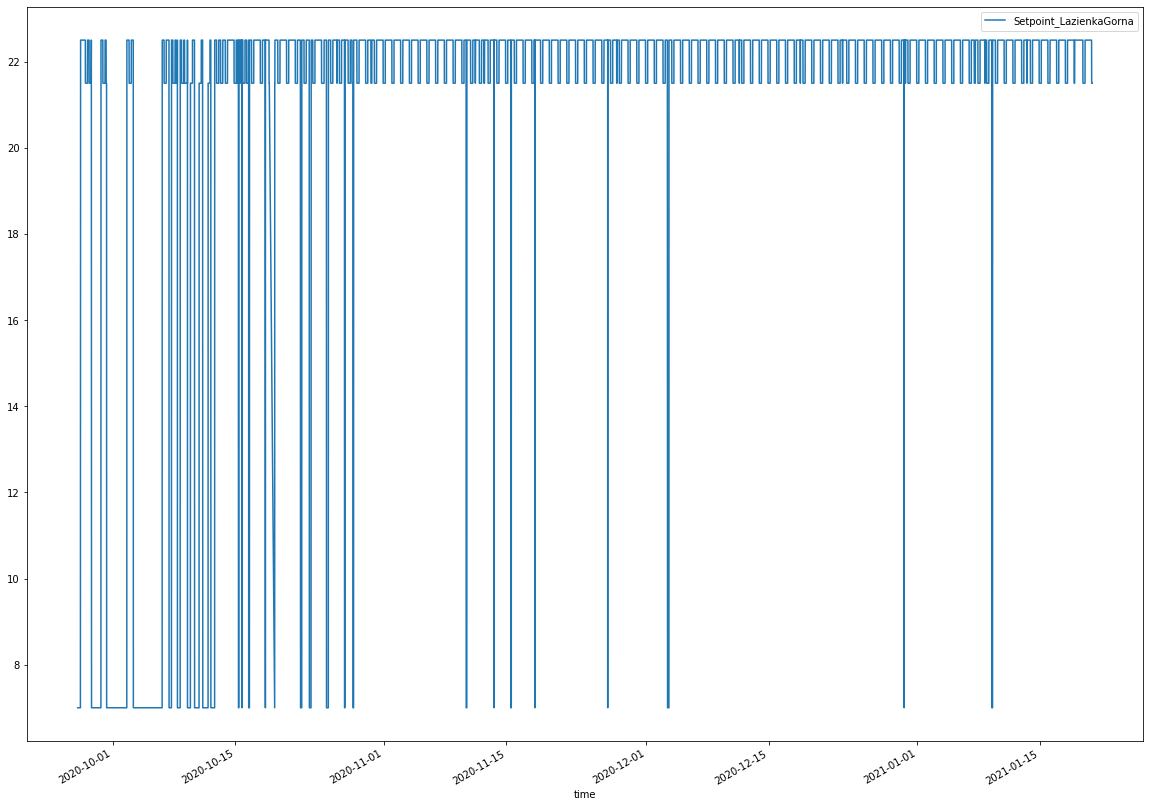

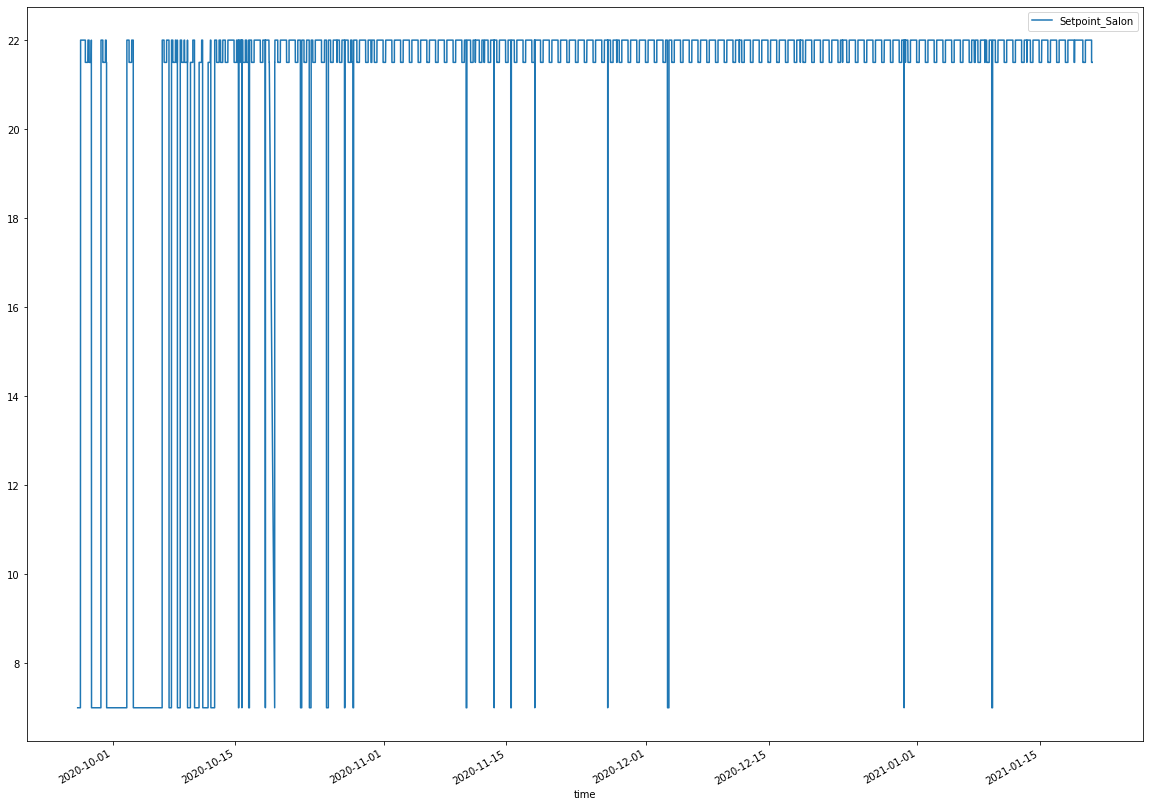

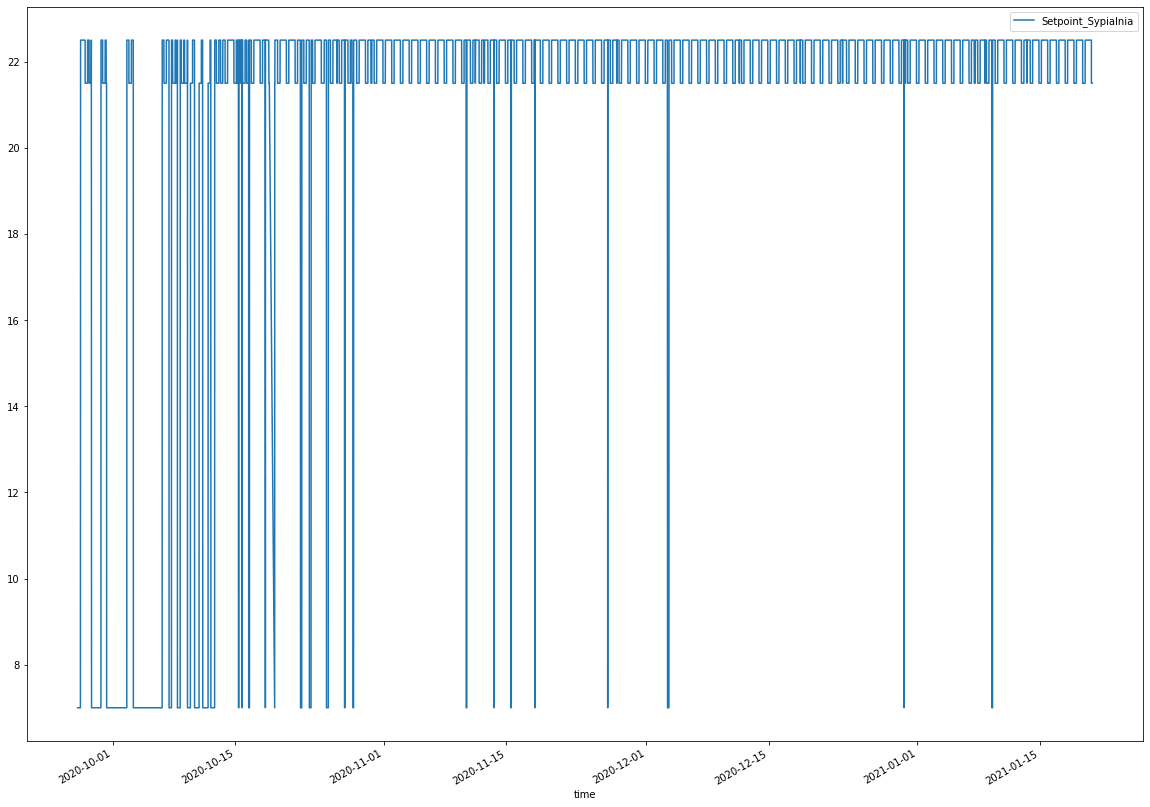

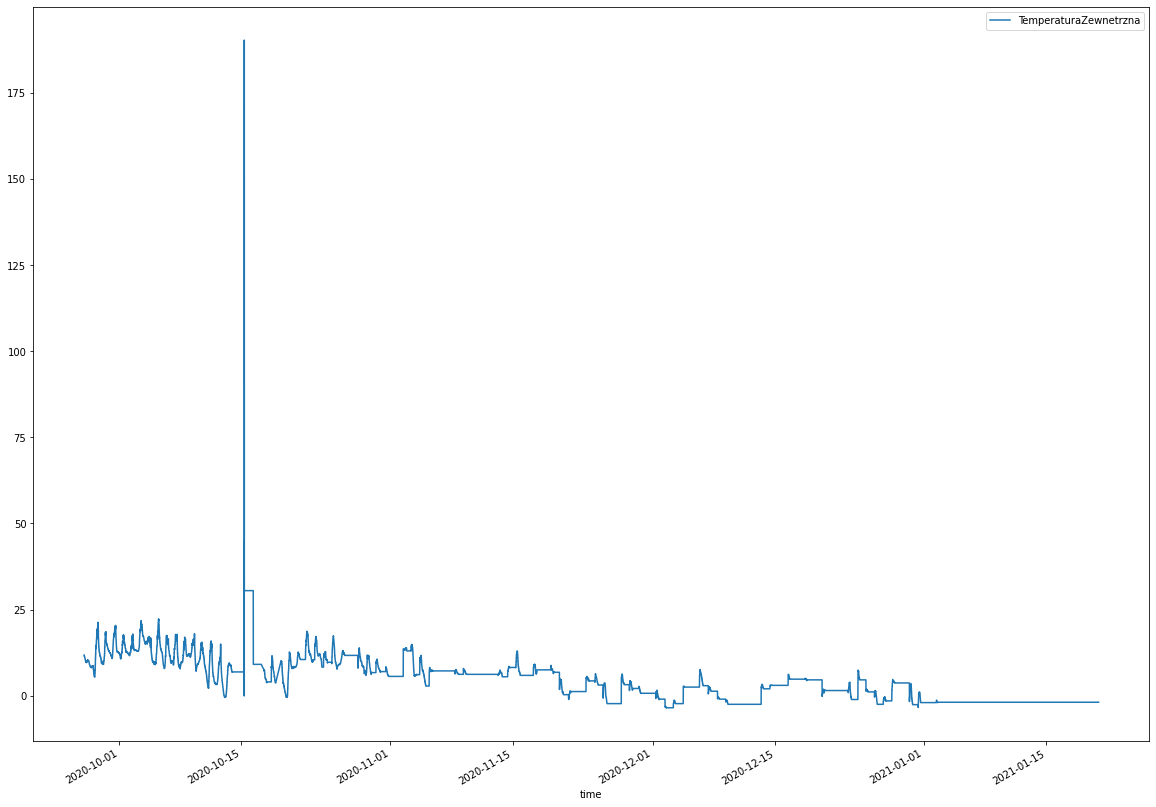

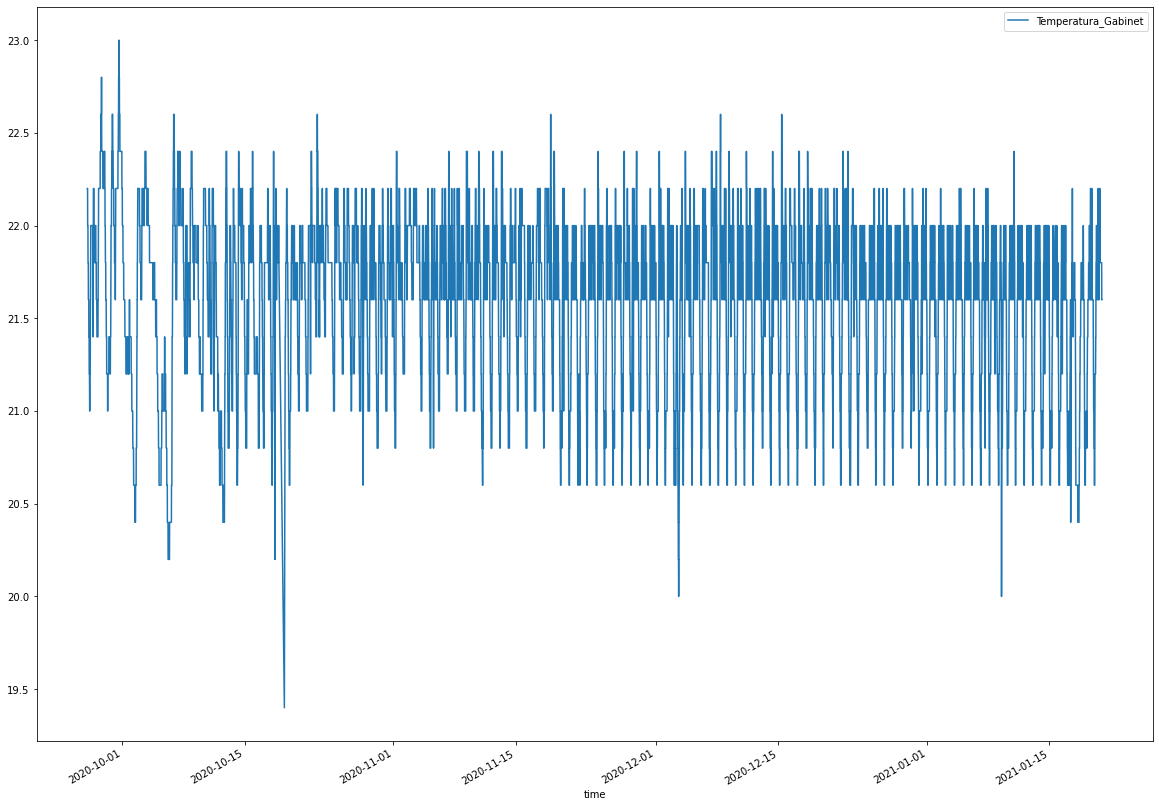

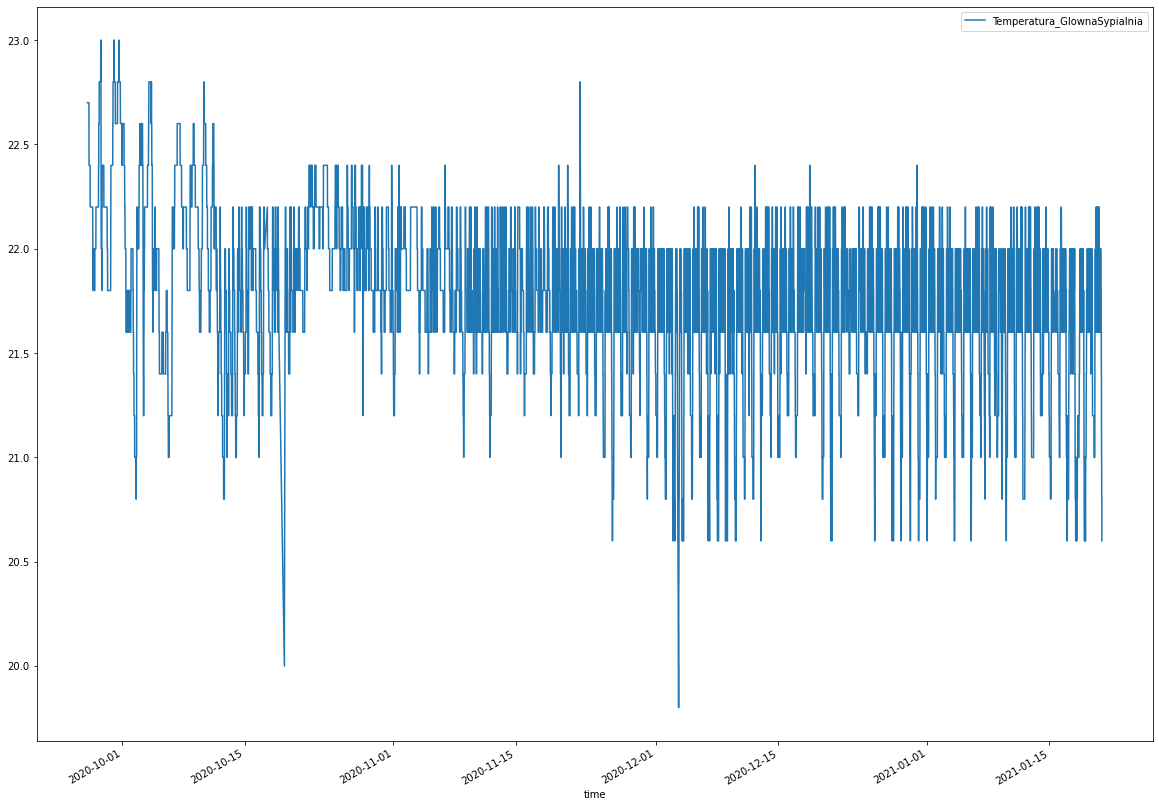

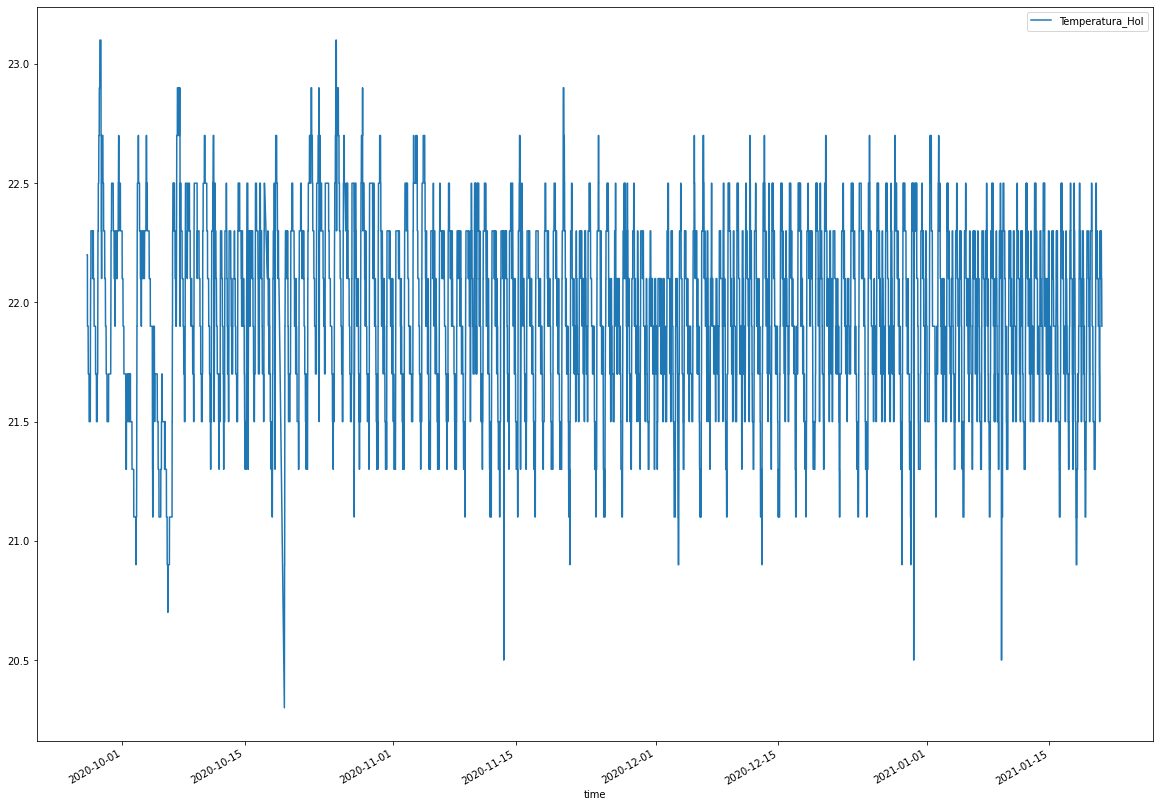

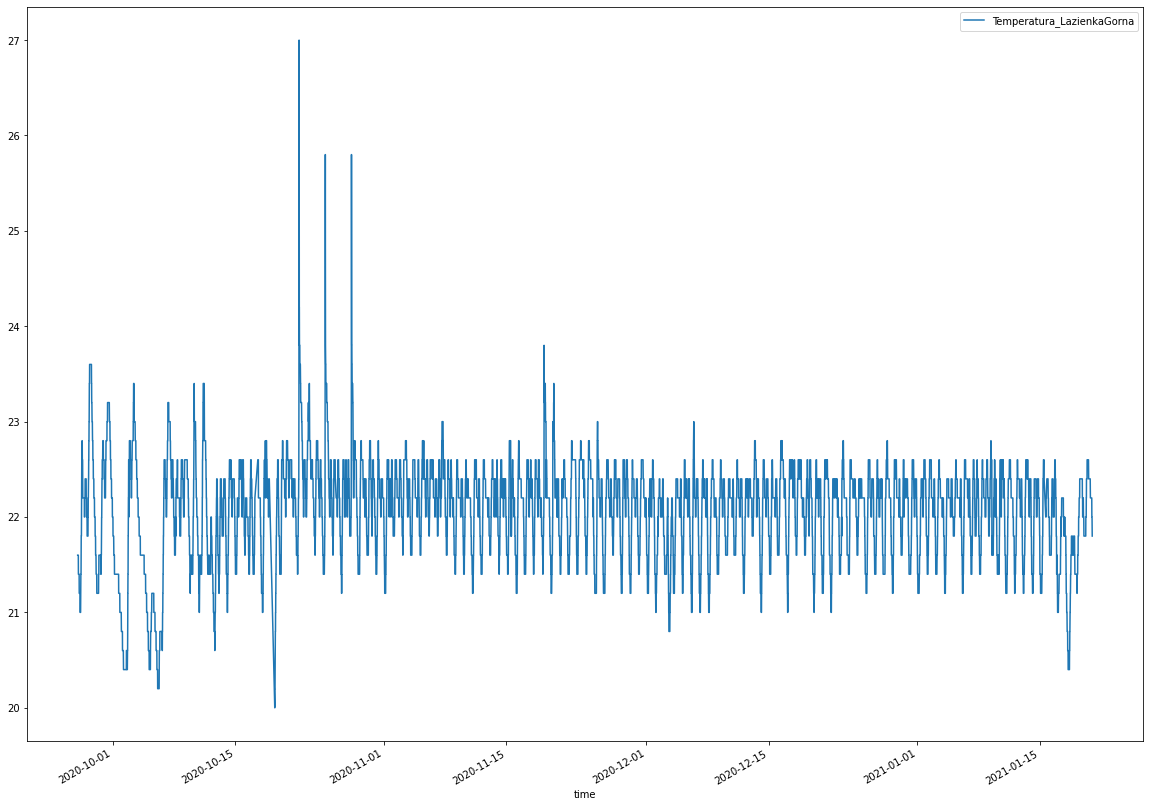

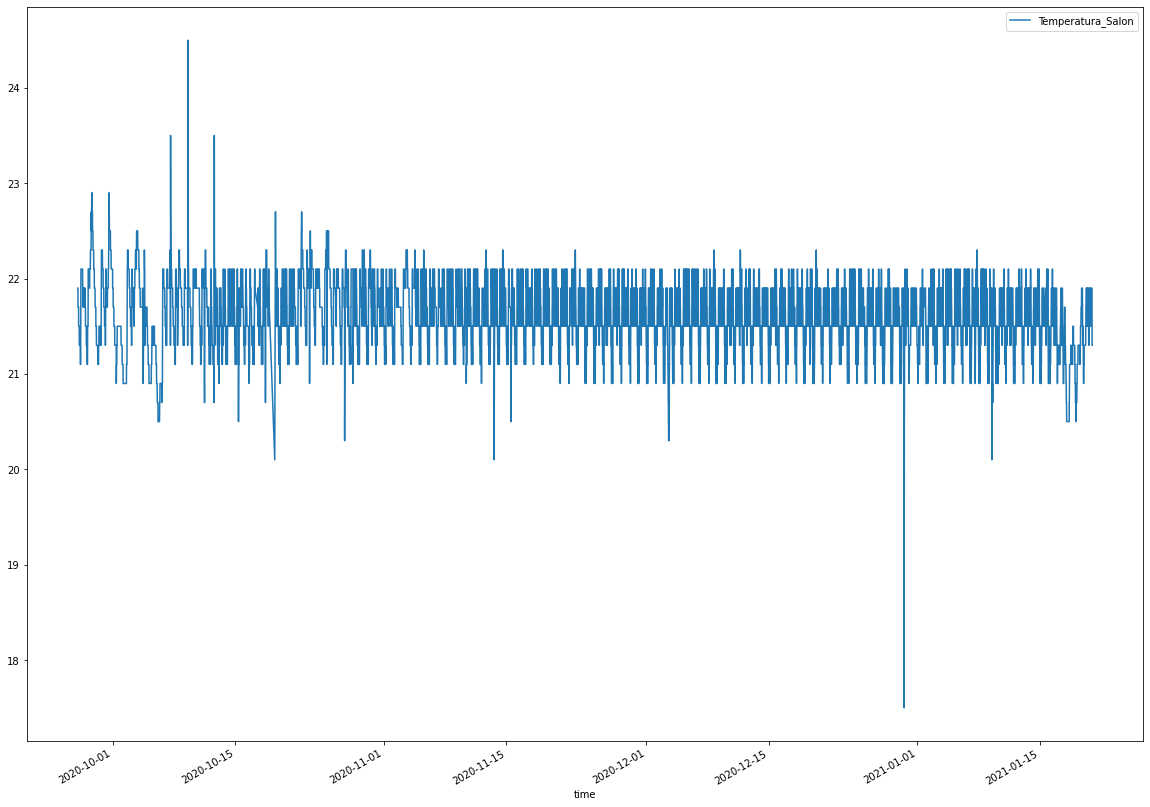

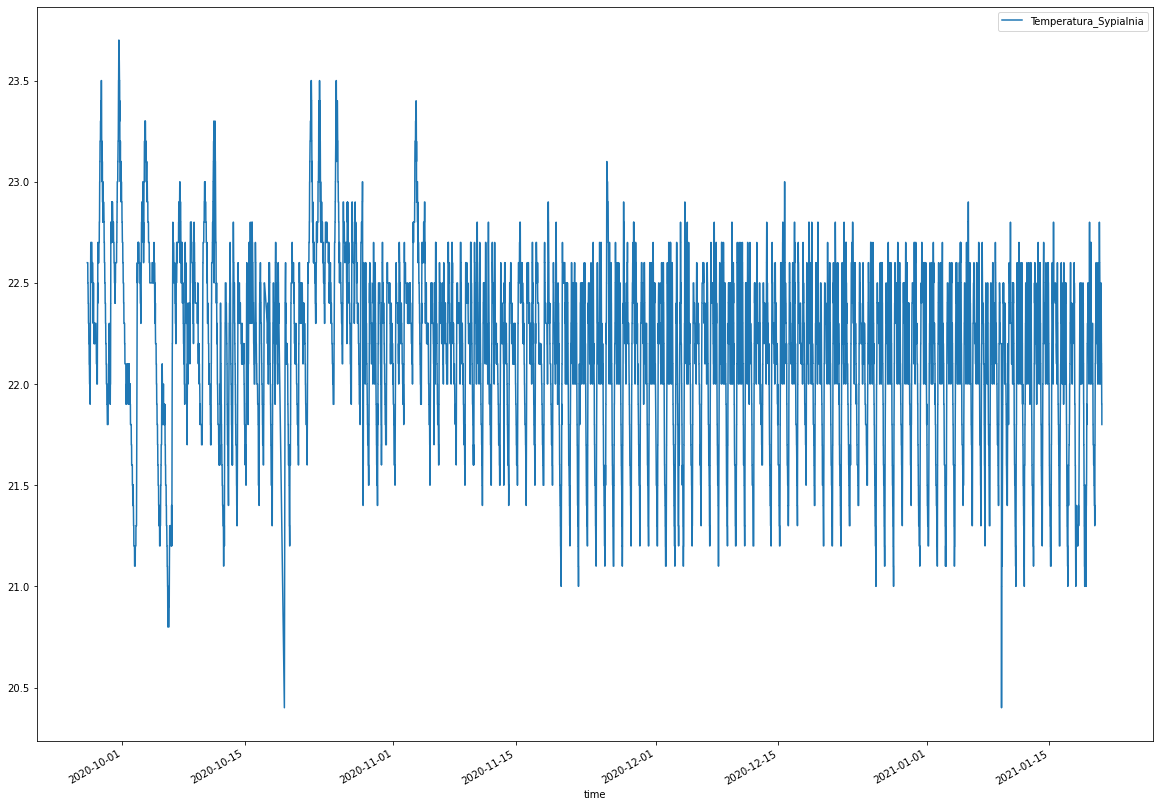

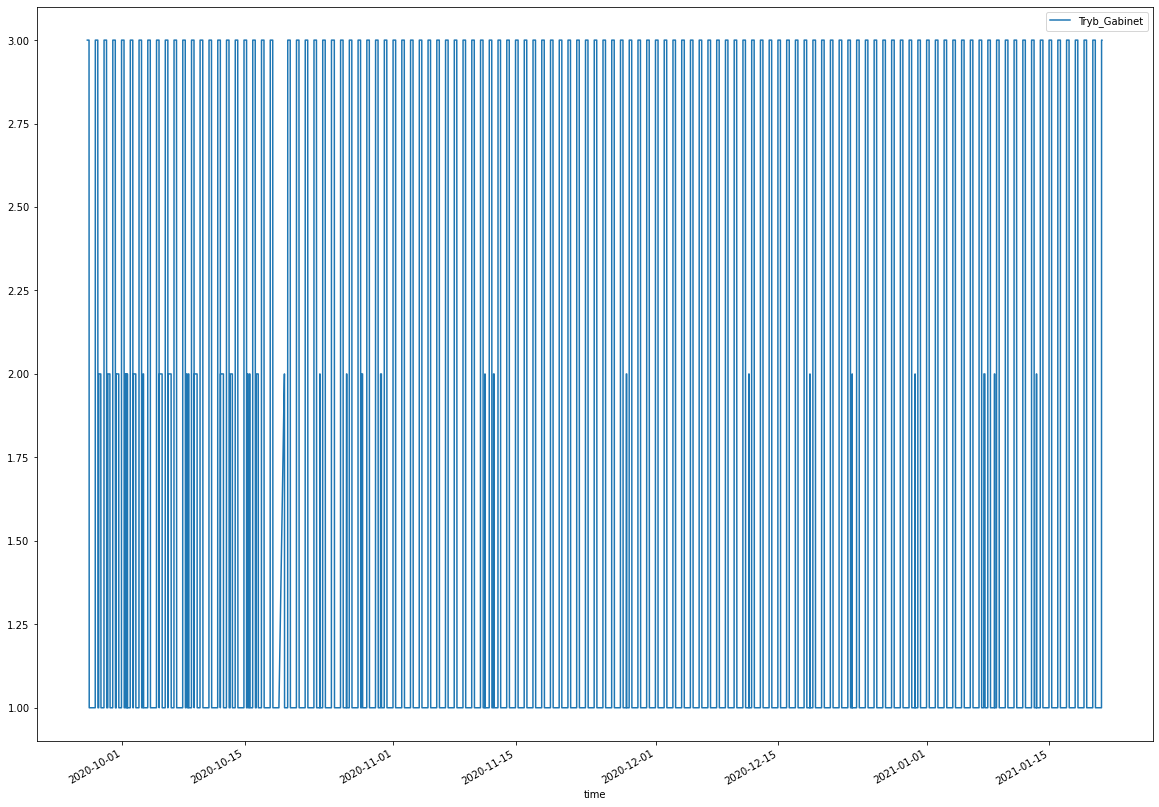

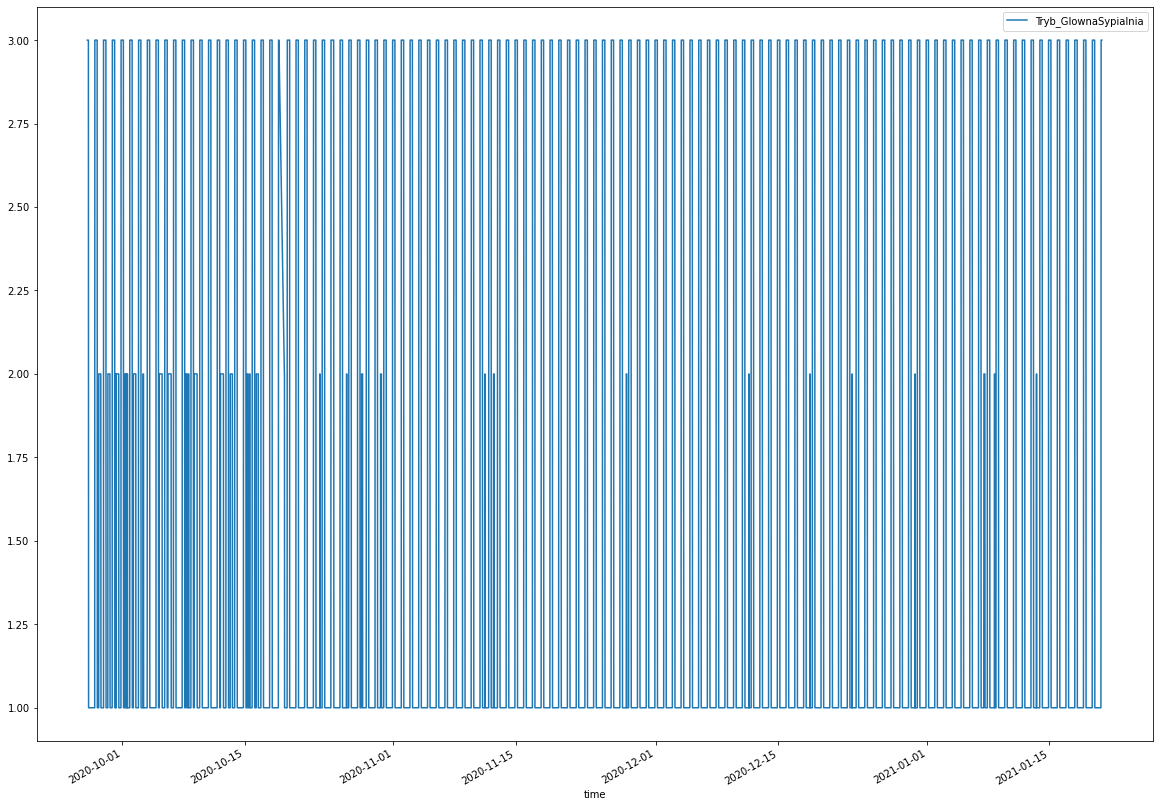

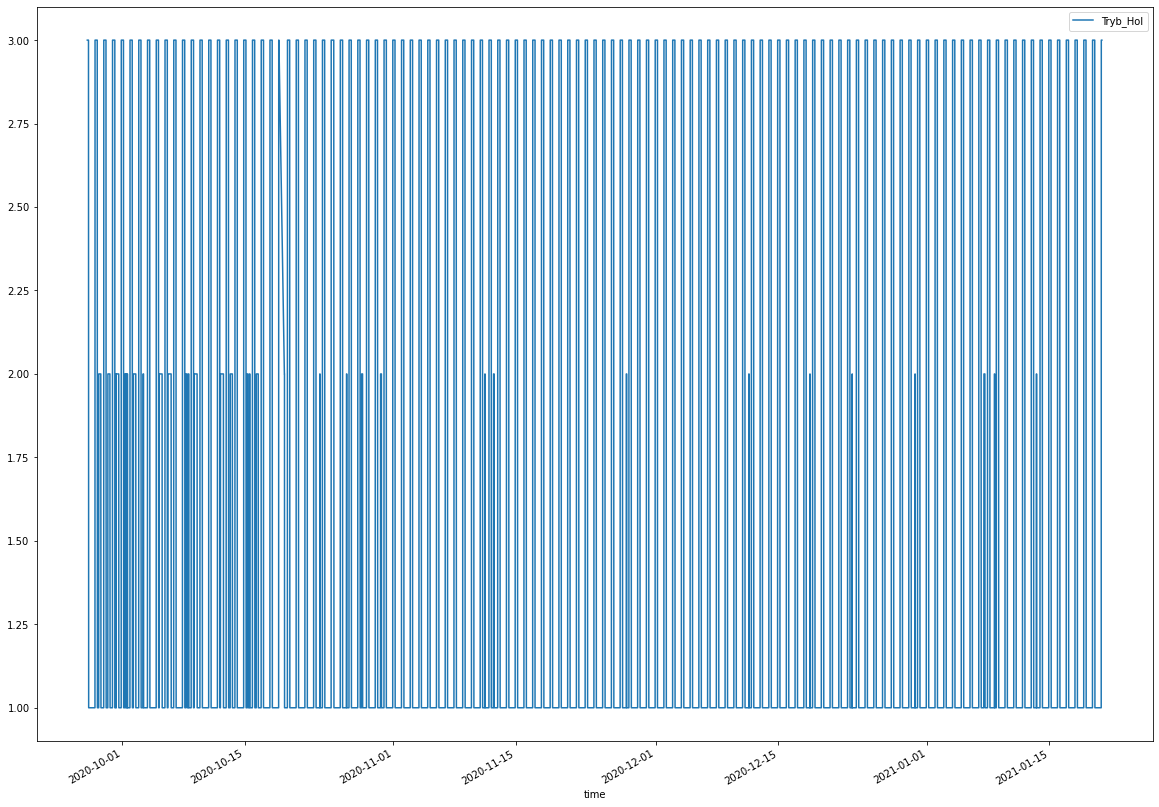

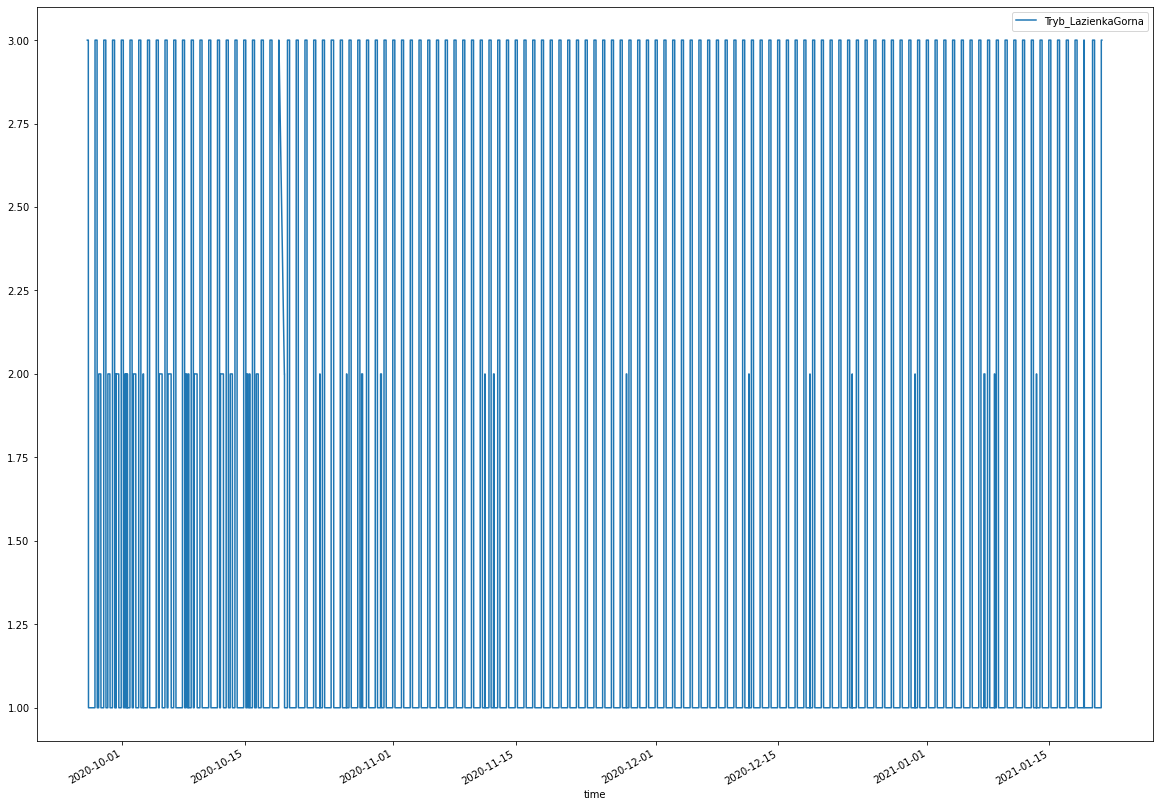

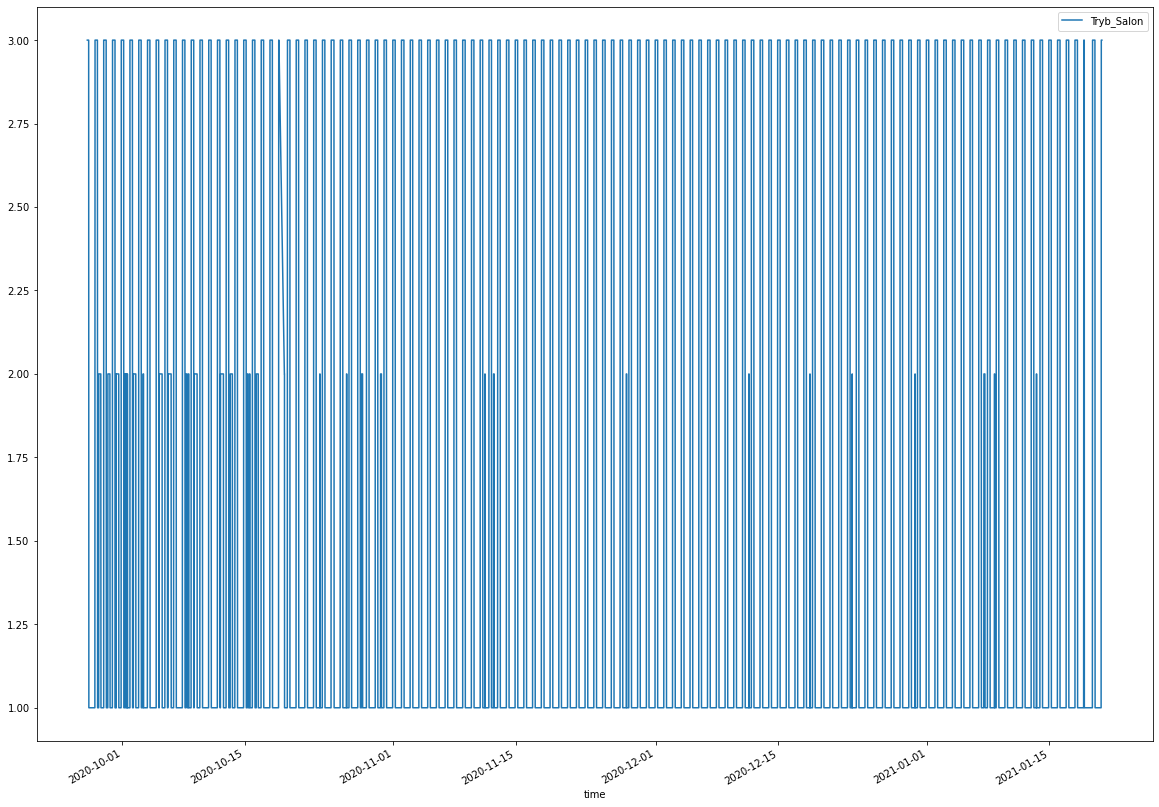

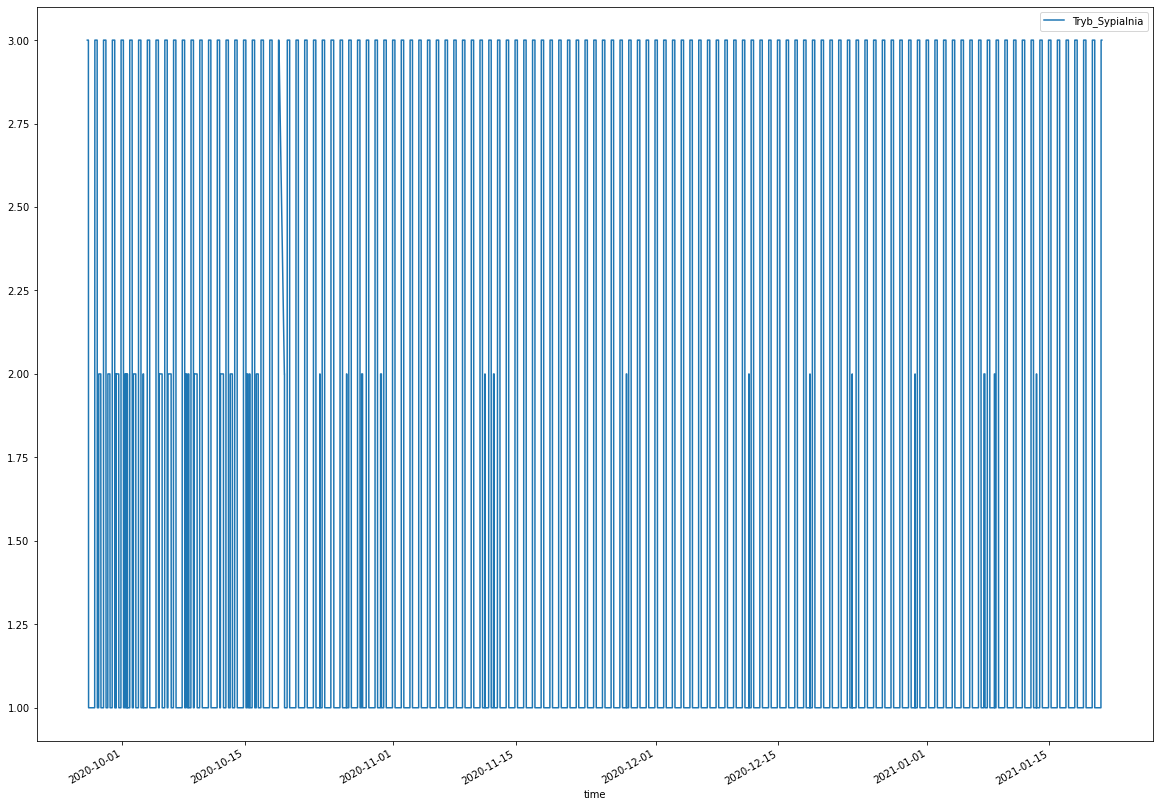

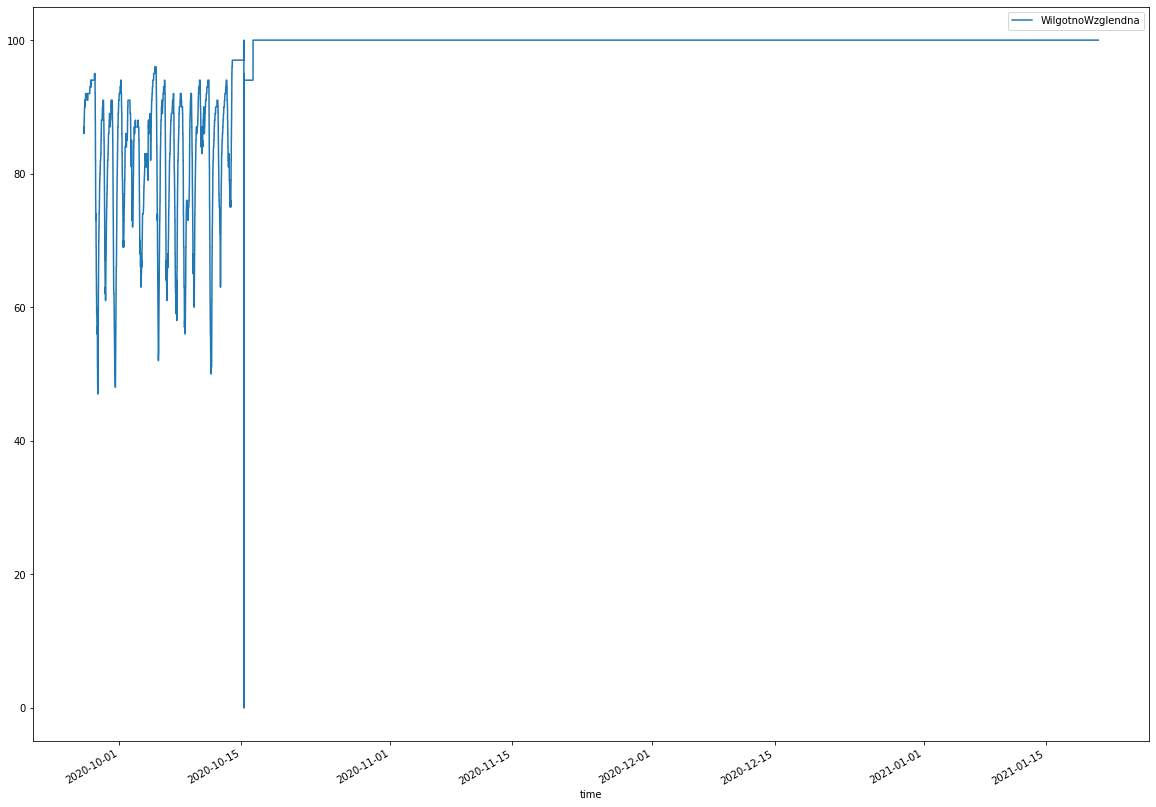

In [5]:
for df in frames:
    _ = df.plot(figsize=(20,15))

In [6]:
del frames[-1] #Relative humidity sensor seems to be broken since mid october

In [7]:
def plot_for_every_month(df, include_spike=True):
    figsize = (20, 15)
    if include_spike:
        df.loc[:pd.to_datetime("2020-10-14T00:00:00")].plot(figsize=figsize)
        df.loc[pd.to_datetime("2020-10-14T00:00:00"):pd.to_datetime("2020-10-17T00:00:00")].plot(figsize=figsize)
        df.loc[pd.to_datetime("2020-10-17T00:00:00"):pd.to_datetime("2020-10-26T00:00:00")].plot(figsize=figsize)
    else:
        df.loc[:pd.to_datetime("2020-10-26T00:00:00")].plot(figsize=figsize)
    df.loc[pd.to_datetime("2020-10-26T00:00:00"):pd.to_datetime("2020-11-26T00:00:00")].plot(figsize=figsize)
    df.loc[pd.to_datetime("2020-11-26T00:00:00"):pd.to_datetime("2020-12-26T00:00:00")].plot(figsize=figsize)
    df.loc[pd.to_datetime("2020-12-26T00:00:00"):pd.to_datetime("2021-01-26T00:00:00")].plot(figsize=figsize)

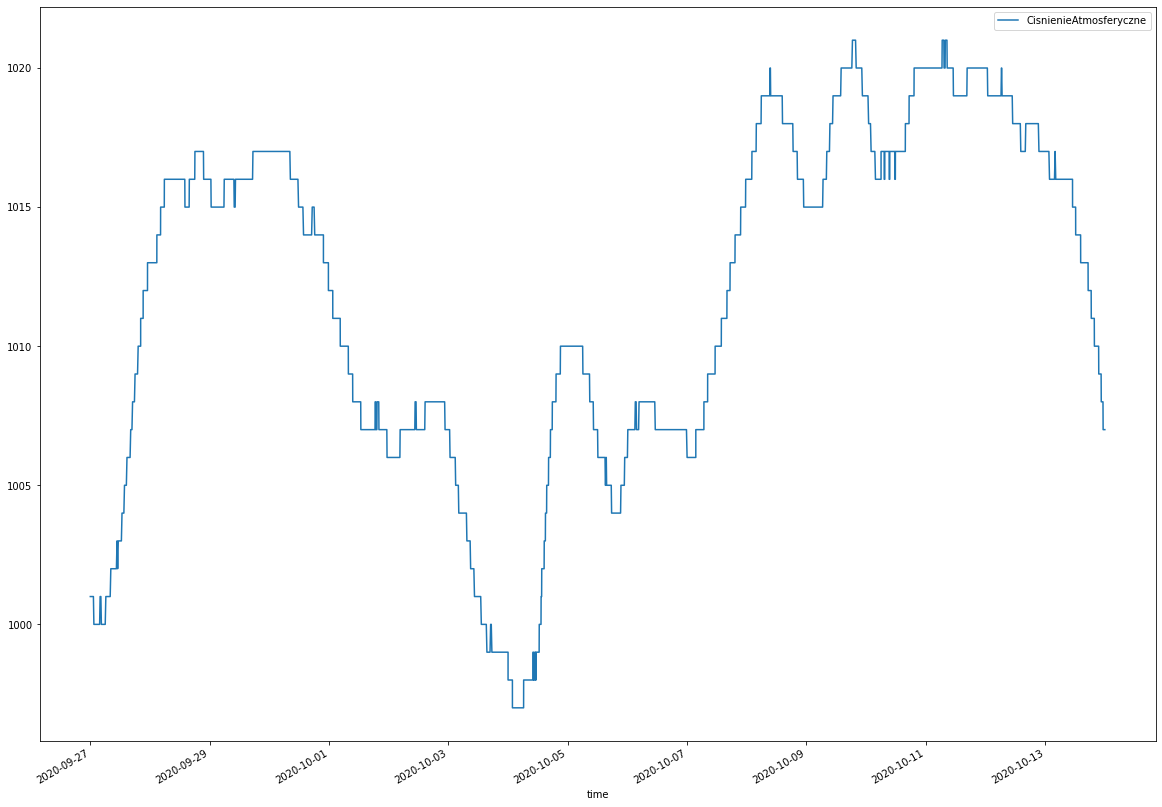

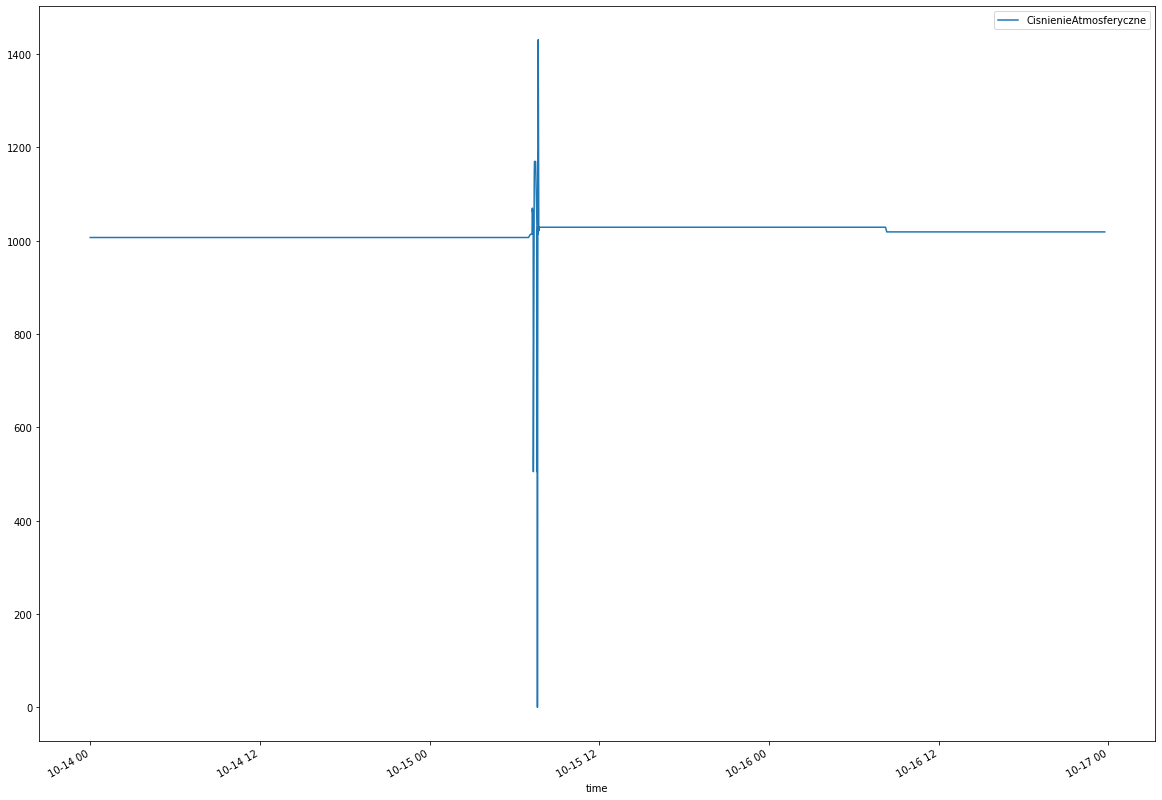

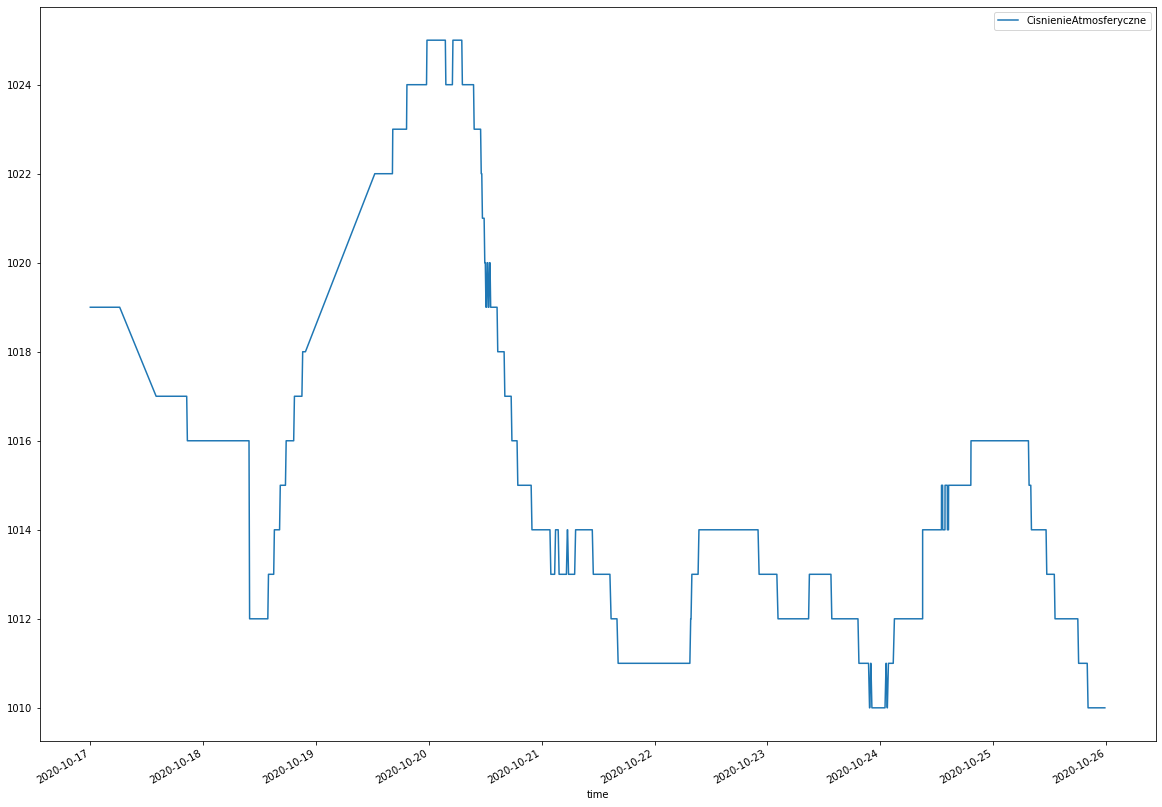

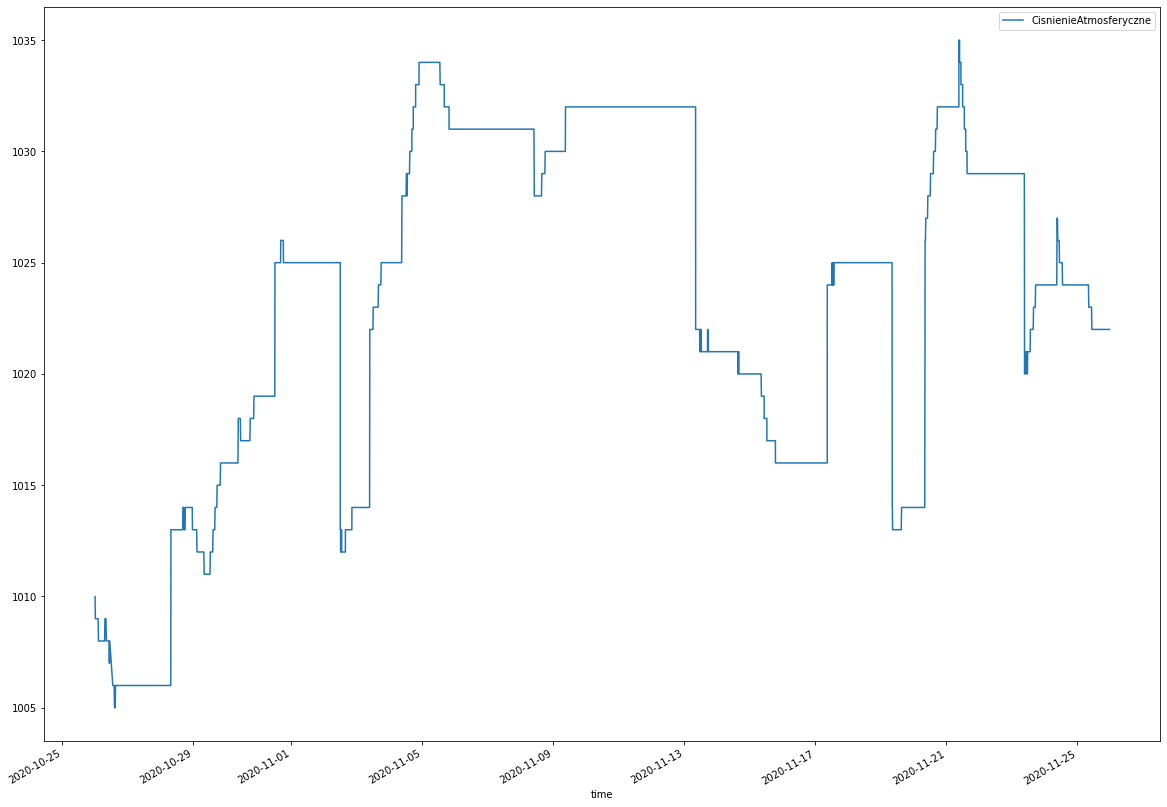

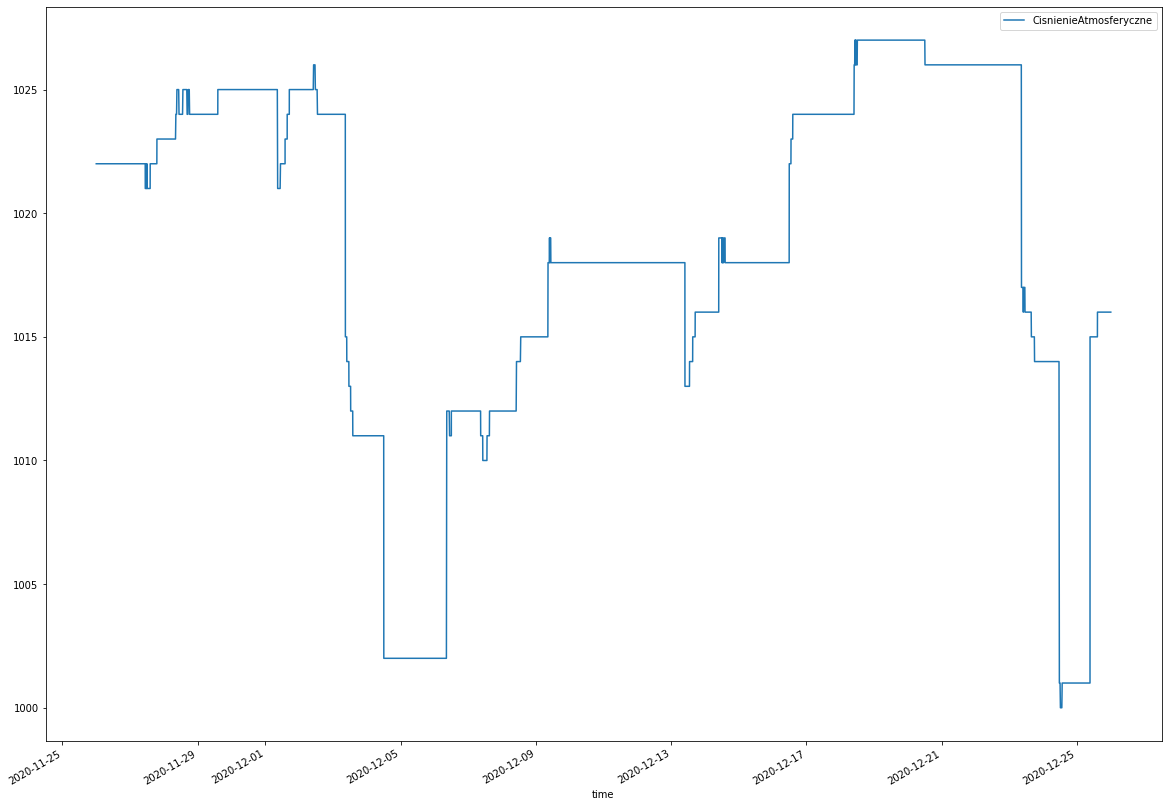

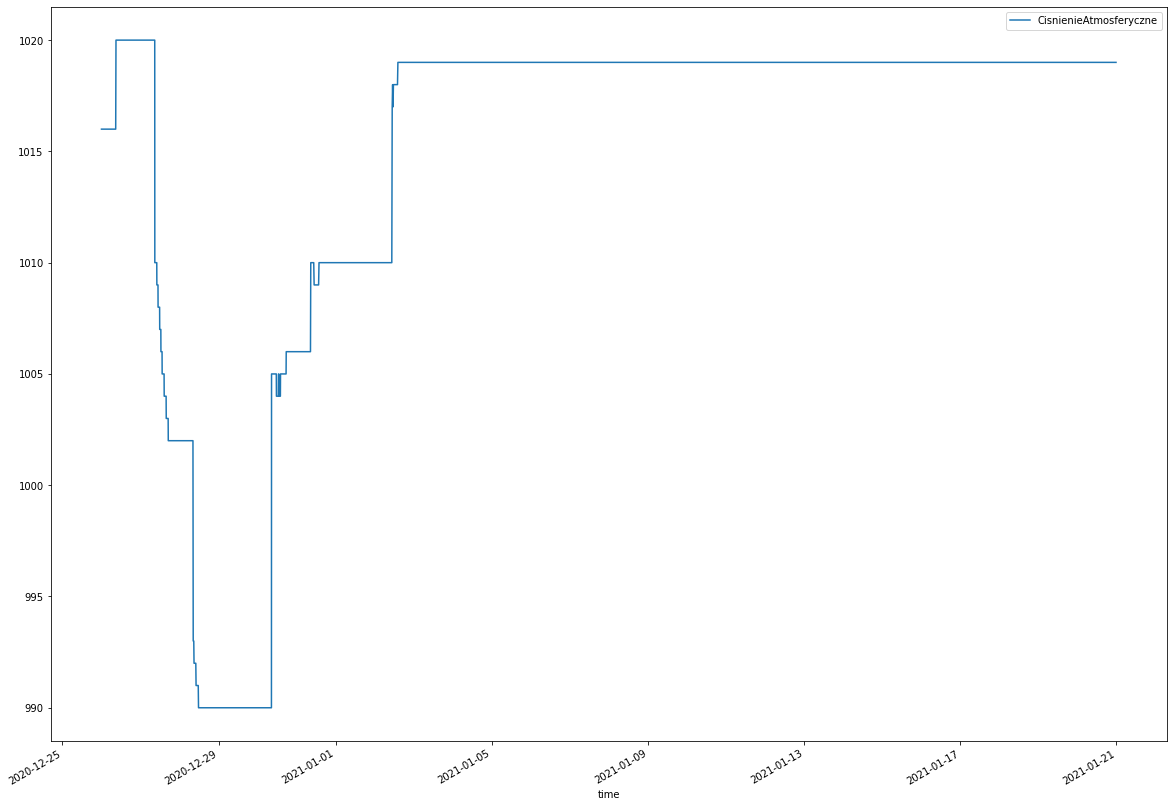

In [8]:
plot_for_every_month(frames[1])

In [9]:
del frames[1] #This data looks a bit too rectangular after the spike in mid october

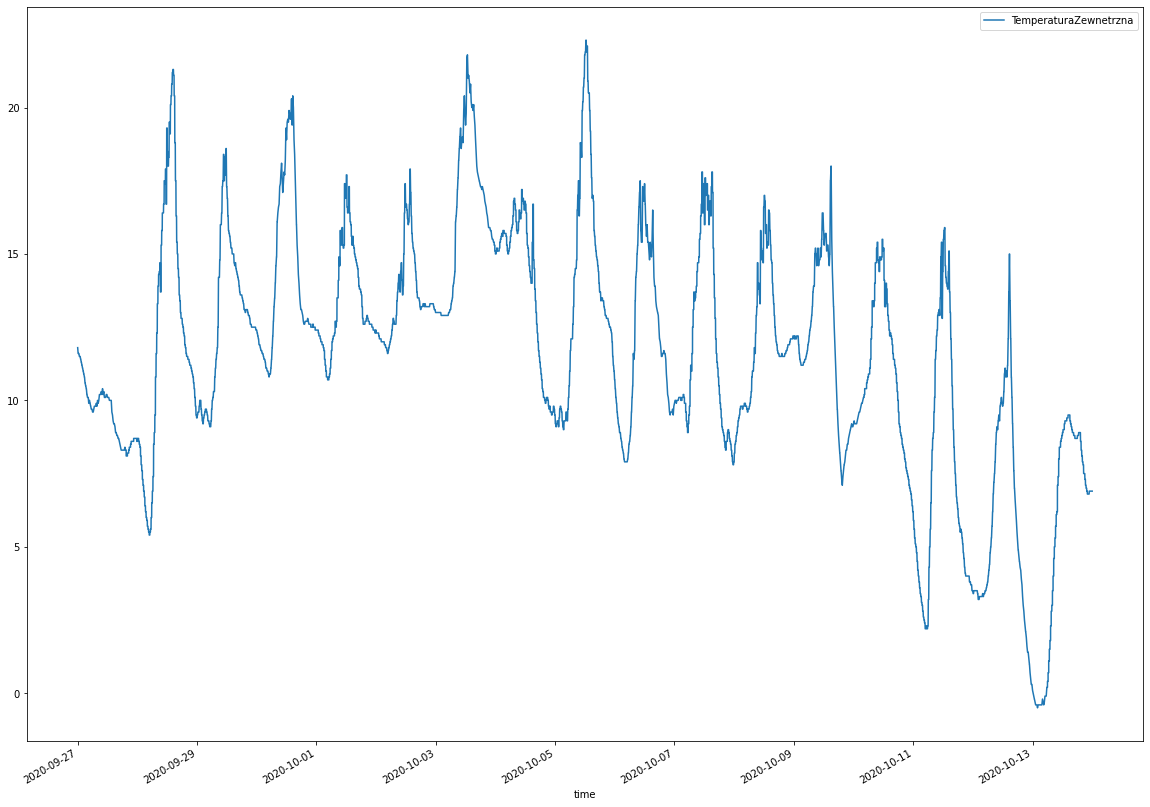

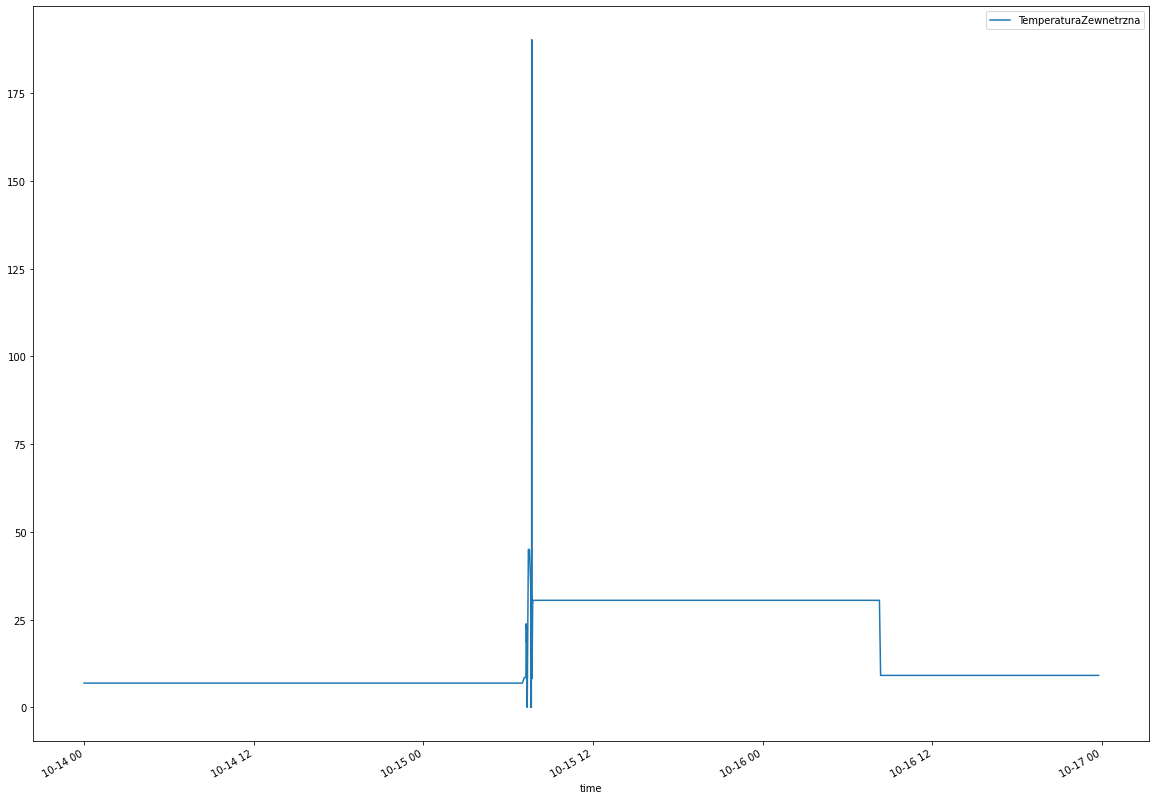

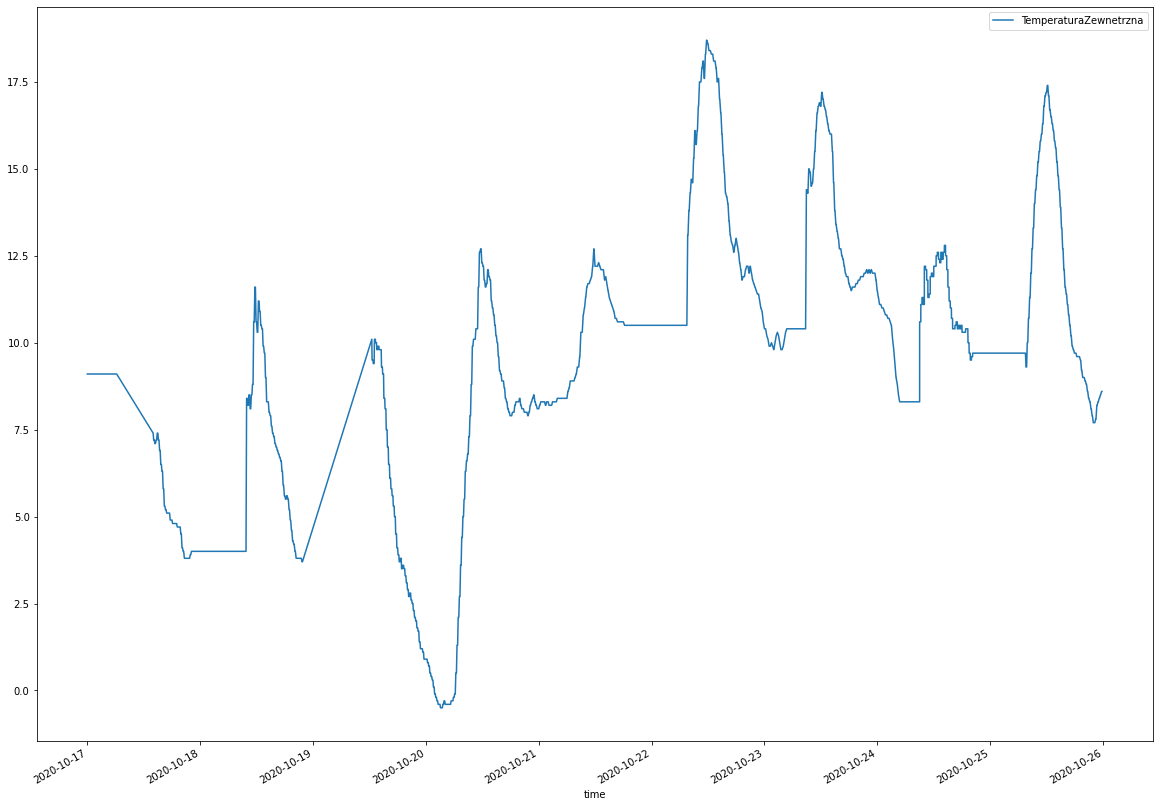

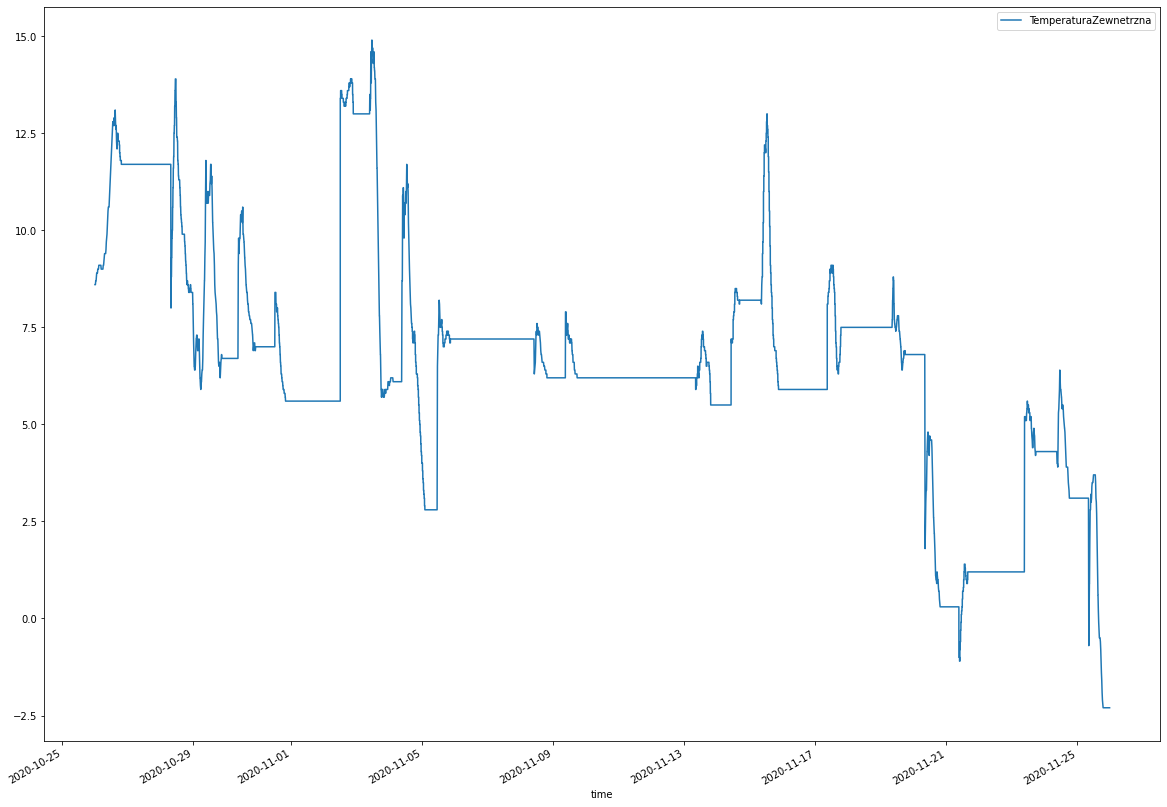

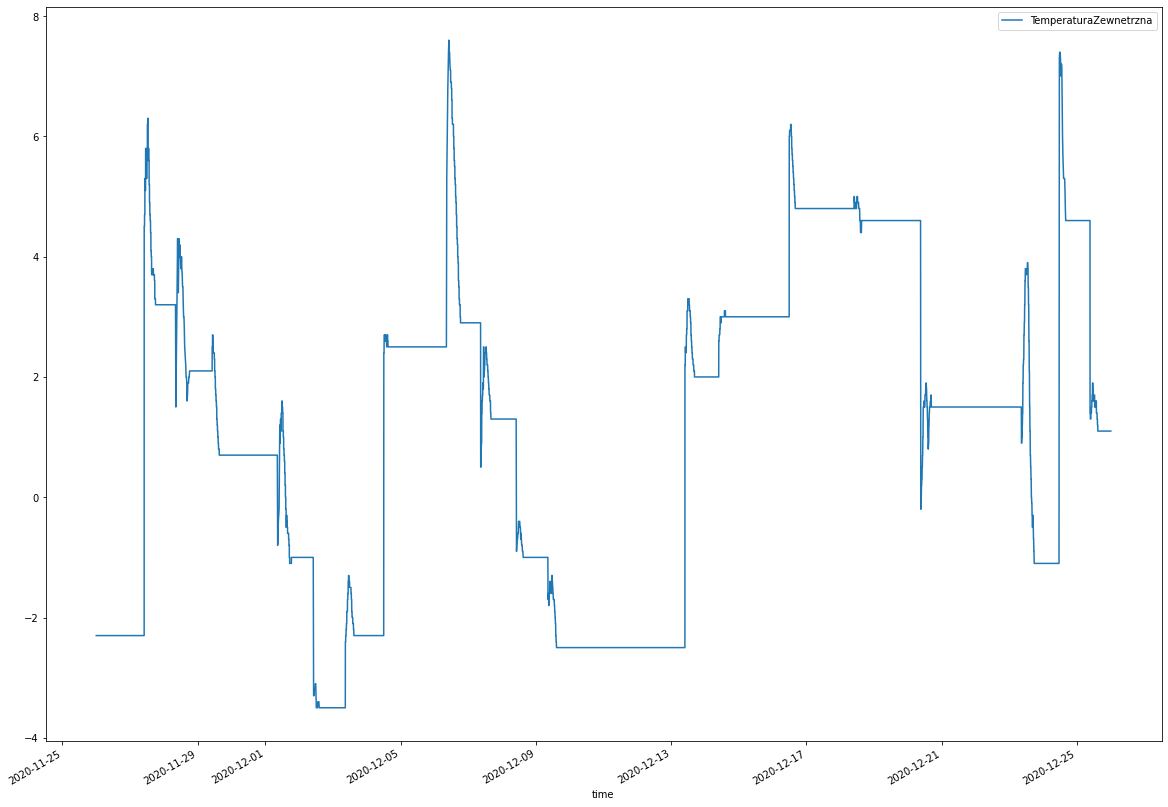

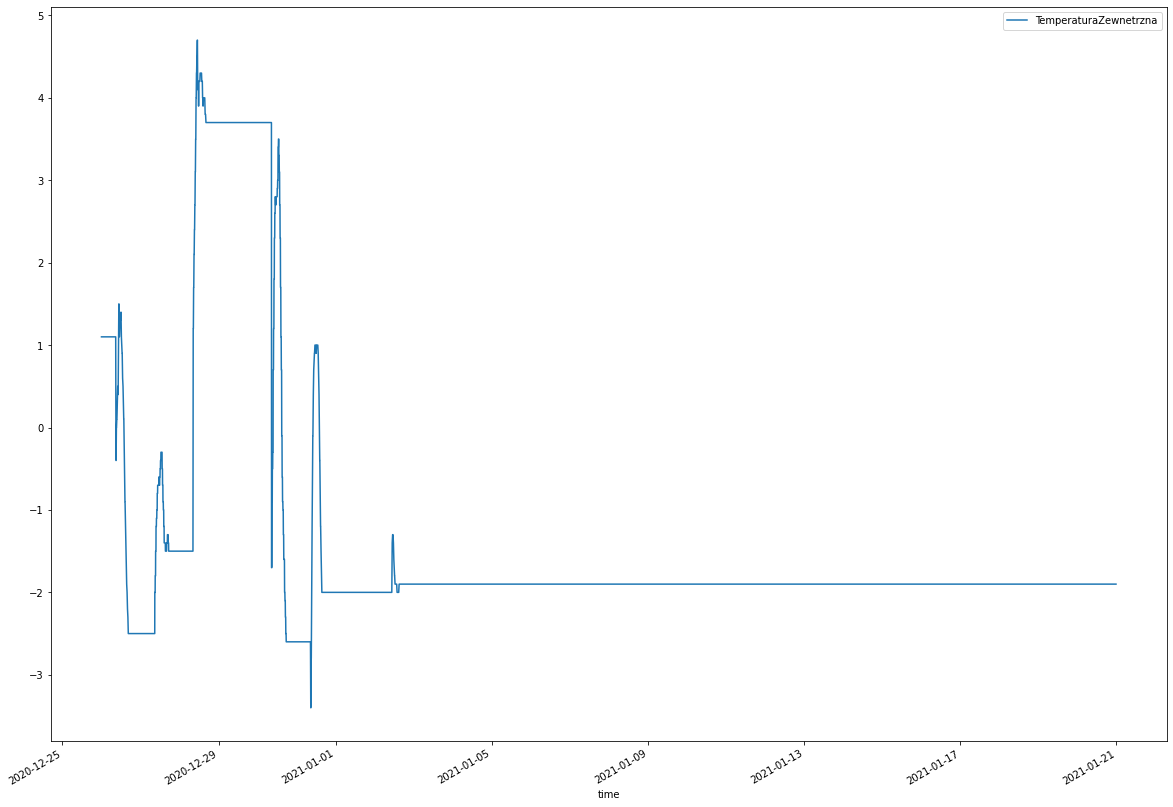

In [10]:
plot_for_every_month(frames[15])

This also becomes more and more rectangular.

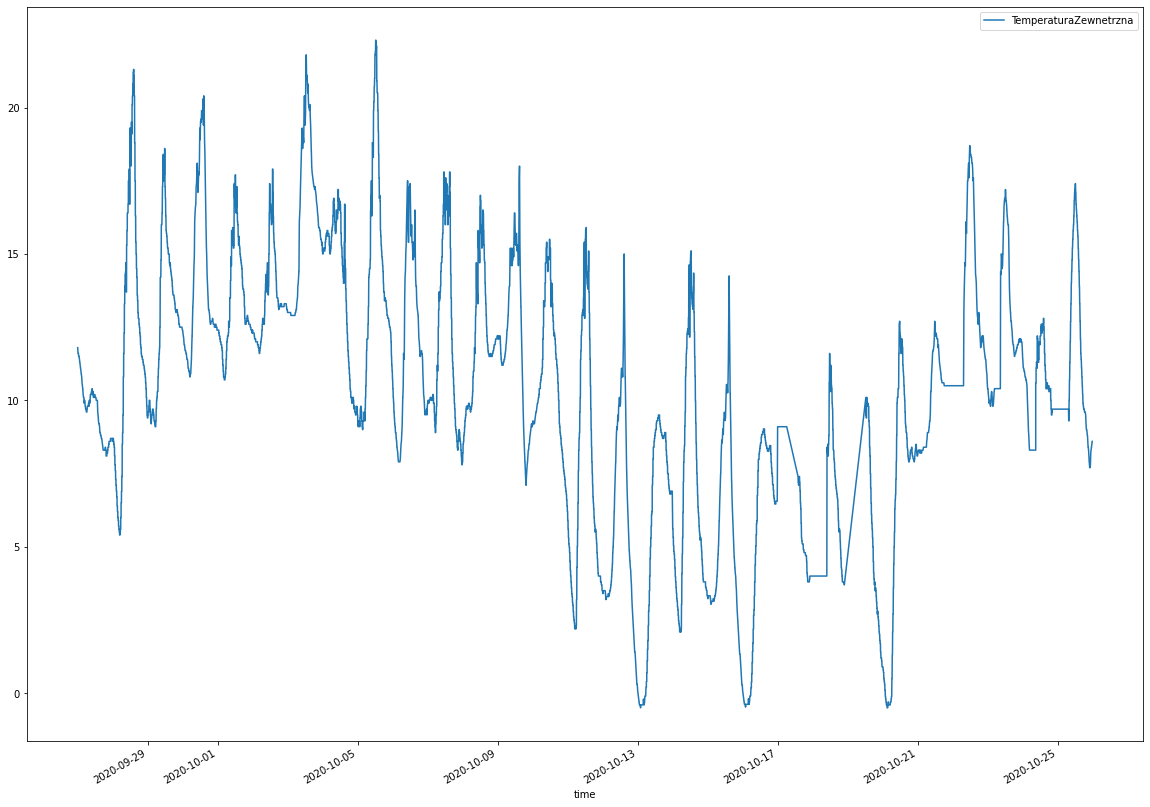

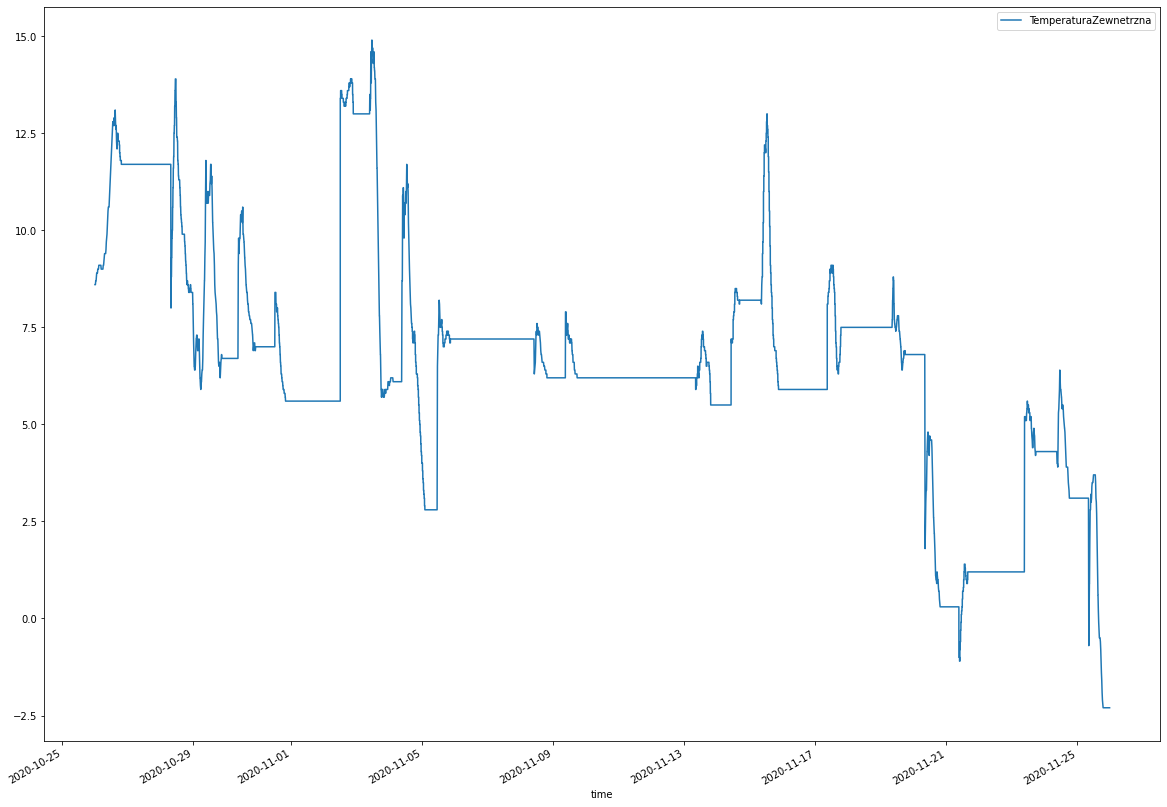

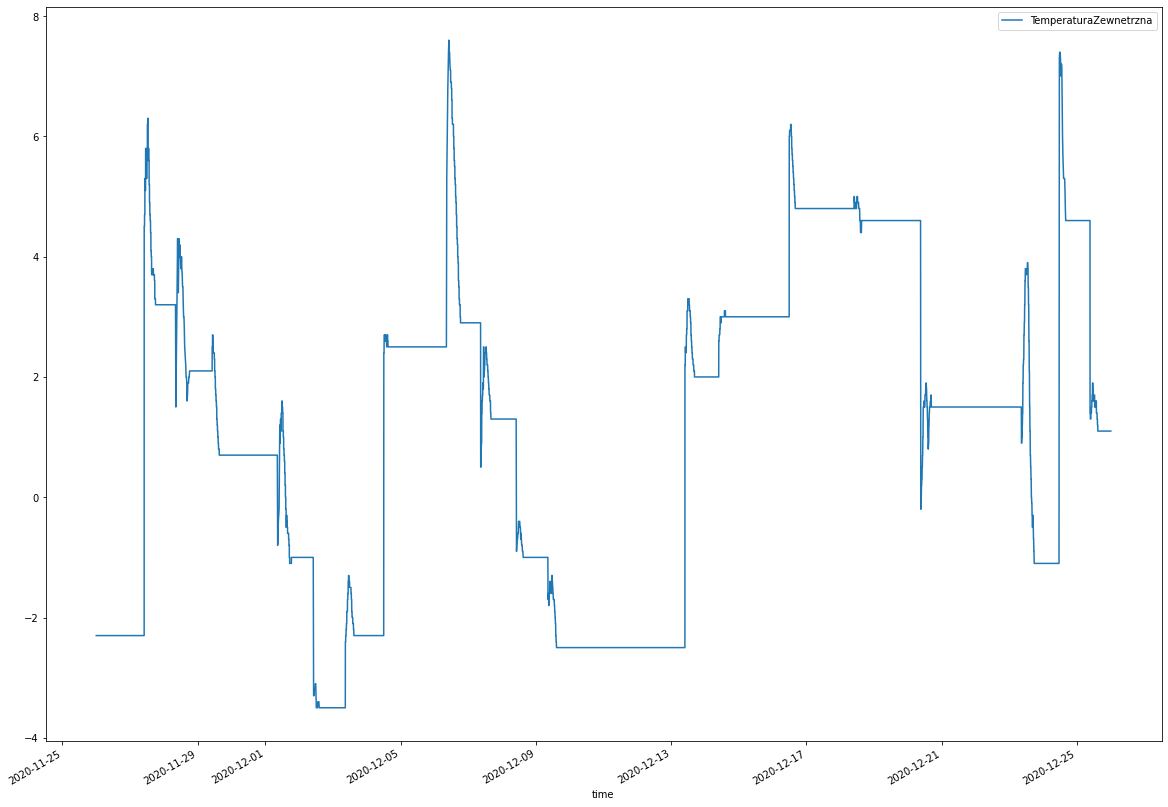

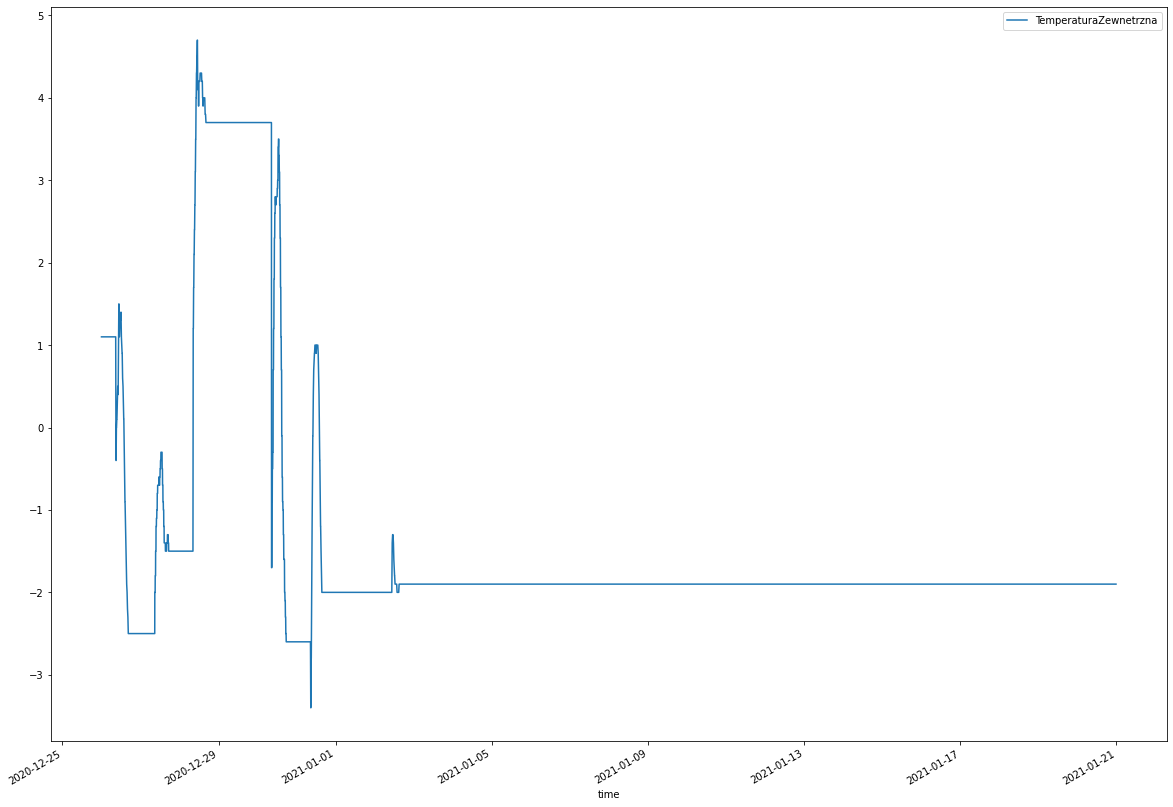

In [11]:
def remove_spike_from_outdoor_temperature(df):
    df = df.copy()
    col_name = df.columns.tolist()[0]
    df = df.reset_index()
    correct_data = df[(df["time"] < pd.to_datetime("2020-10-14T00:00:00")) | (df["time"] >= pd.to_datetime("2020-10-17T00:00:00"))]
    spike_data = df[(df["time"] >= pd.to_datetime("2020-10-11T00:00:00")) & (df["time"] < pd.to_datetime("2020-10-14T00:00:00"))]
    spike_data["time"] = spike_data["time"].apply(lambda x: x + pd.DateOffset(3))
    spike_data[col_name] = correct_data[col_name] * 0.95
    correct_data = correct_data.append(spike_data)
    correct_data = correct_data.sort_values(by="time")
    df = correct_data.set_index("time")
    return df

frames[15] = remove_spike_from_outdoor_temperature(frames[15])
plot_for_every_month(frames[15], include_spike=False)

In [12]:
def remove_duplicates(frames: list) -> list:
    return [frame[~frame.index.duplicated()] for frame in frames]
frames = remove_duplicates(frames)

In [13]:
def merge_frames_and_resample_to_1min_intervals(frames: list) -> pd.DataFrame:
    df = None
    for frame in frames:
        col_name = frame.columns.tolist()[0]
        new_df = frame.asfreq("1min", method="backfill")
        if df is None:
            df = new_df
        else:
            df[col_name] = new_df[col_name]
    return df

data = merge_frames_and_resample_to_1min_intervals(frames)

In [14]:
data.head()

Centralne_BlokadaOgrzewania  EGardenCzujnikDeszczu  \
time                                                                      
2020-09-27 00:00:00                            1                      0   
2020-09-27 00:01:00                            1                      0   
2020-09-27 00:02:00                            1                      0   
2020-09-27 00:03:00                            1                      0   
2020-09-27 00:04:00                            1                      0   

                     Grzejnik_BlokadaKotlaCO  Grzejnik_Gabinet  \
time                                                             
2020-09-27 00:00:00                        1                 0   
2020-09-27 00:01:00                        1                 0   
2020-09-27 00:02:00                        1                 0   
2020-09-27 00:03:00                        1                 0   
2020-09-27 00:04:00                        1                 0   

                     Grzejnik_Glowna_Sypialnia  \
time                                             
2020-09-27 00:00:00                          0   
2020-09-27 00:01:00                          0   
2020-09-27 00:02:00                          0   
2020-09-27 00:03:00                          0   
2020-09-27 00:04:00                          0   

                     Grzejnik_LazienkaGorna_Podlogowka  \
time                                                     
2020-09-27 00:00:00                                  0   
2020-09-27 00:01:00                                  0   
2020-09-27 00:02:00                                  0   
2020-09-27 00:03:00                                  0   
2020-09-27 00:04:00                                  0   

                     Grzejnik_Parter_Podlogowka  Grzejnik_Salon  \
time                                                              
2020-09-27 00:00:00                           0               0   
2020-09-27 00:01:00                           0               0   
2020-09-27 00:02:00                           0               0   
2020-09-27 00:03:00                           0               0   
2020-09-27 00:04:00                           0               0   

                     Grzejnik_Sypialnia  Setpoint_Gabinet  \
time                                                        
2020-09-27 00:00:00                   0                 7   
2020-09-27 00:01:00                   0                 7   
2020-09-27 00:02:00                   0                 7   
2020-09-27 00:03:00                   0                 7   
2020-09-27 00:04:00                   0                 7   

                     Setpoint_GlownaSypialnia  Setpoint_Hol  \
time                                                          
2020-09-27 00:00:00                         7           7.0   
2020-09-27 00:01:00                         7           7.0   
2020-09-27 00:02:00                         7           7.0   
2020-09-27 00:03:00                         7           7.0   
2020-09-27 00:04:00                         7           7.0   

                     Setpoint_LazienkaGorna  Setpoint_Salon  \
time                                                          
2020-09-27 00:00:00                     7.0             7.0   
2020-09-27 00:01:00                     7.0             7.0   
2020-09-27 00:02:00                     7.0             7.0   
2020-09-27 00:03:00                     7.0             7.0   
2020-09-27 00:04:00                     7.0             7.0   

                     Setpoint_Sypialnia  TemperaturaZewnetrzna  \
time                                                             
2020-09-27 00:00:00                 7.0                   11.8   
2020-09-27 00:01:00                 7.0                   11.6   
2020-09-27 00:02:00                 7.0                   11.6   
2020-09-27 00:03:00                 7.0                   11.6   
2020-09-27 00:04:00                 7.0                   11.6   

                     Temperat

In [15]:
def calculate_how_long_was_heating_turned_on_in_last_hour(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    heating_cols = [col_name for col_name in df.columns.tolist() if col_name.lower().startswith("grzejnik")]

    def func(x):
        curr_time = x.name
        hour_ago = curr_time - pd.DateOffset(hours=1)
        for col in heating_cols:
            new_col = f"{col}_hourly_sum"
            x[new_col] = df.loc[hour_ago:curr_time, col].sum()
        return x

    for col in heating_cols:
        df[f"{col}_hourly_sum"] = 0
    return df.apply(func, axis=1)

new_data = calculate_how_long_was_heating_turned_on_in_last_hour(data)

In [16]:
new_data.head()

Centralne_BlokadaOgrzewania  EGardenCzujnikDeszczu  \
time                                                                      
2020-09-27 00:00:00                          1.0                    0.0   
2020-09-27 00:01:00                          1.0                    0.0   
2020-09-27 00:02:00                          1.0                    0.0   
2020-09-27 00:03:00                          1.0                    0.0   
2020-09-27 00:04:00                          1.0                    0.0   

                     Grzejnik_BlokadaKotlaCO  Grzejnik_Gabinet  \
time                                                             
2020-09-27 00:00:00                      1.0               0.0   
2020-09-27 00:01:00                      1.0               0.0   
2020-09-27 00:02:00                      1.0               0.0   
2020-09-27 00:03:00                      1.0               0.0   
2020-09-27 00:04:00                      1.0               0.0   

                     Grzejnik_Glowna_Sypialnia  \
time                                             
2020-09-27 00:00:00                        0.0   
2020-09-27 00:01:00                        0.0   
2020-09-27 00:02:00                        0.0   
2020-09-27 00:03:00                        0.0   
2020-09-27 00:04:00                        0.0   

                     Grzejnik_LazienkaGorna_Podlogowka  \
time                                                     
2020-09-27 00:00:00                                0.0   
2020-09-27 00:01:00                                0.0   
2020-09-27 00:02:00                                0.0   
2020-09-27 00:03:00                                0.0   
2020-09-27 00:04:00                                0.0   

                     Grzejnik_Parter_Podlogowka  Grzejnik_Salon  \
time                                                              
2020-09-27 00:00:00                         0.0             0.0   
2020-09-27 00:01:00                         0.0             0.0   
2020-09-27 00:02:00                         0.0             0.0   
2020-09-27 00:03:00                         0.0             0.0   
2020-09-27 00:04:00                         0.0             0.0   

                     Grzejnik_Sypialnia  Setpoint_Gabinet  \
time                                                        
2020-09-27 00:00:00                 0.0               7.0   
2020-09-27 00:01:00                 0.0               7.0   
2020-09-27 00:02:00                 0.0               7.0   
2020-09-27 00:03:00                 0.0               7.0   
2020-09-27 00:04:00                 0.0               7.0   

                     Setpoint_GlownaSypialnia  Setpoint_Hol  \
time                                                          
2020-09-27 00:00:00                       7.0           7.0   
2020-09-27 00:01:00                       7.0           7.0   
2020-09-27 00:02:00                       7.0           7.0   
2020-09-27 00:03:00                       7.0           7.0   
2020-09-27 00:04:00                       7.0           7.0   

                     Setpoint_LazienkaGorna  Setpoint_Salon  \
time                                                          
2020-09-27 00:00:00                     7.0             7.0   
2020-09-27 00:01:00                     7.0             7.0   
2020-09-27 00:02:00                     7.0             7.0   
2020-09-27 00:03:00                     7.0             7.0   
2020-09-27 00:04:00                     7.0             7.0   

                     Setpoint_Sypialnia  TemperaturaZewnetrzna  \
time                                                             
2020-09-27 00:00:00                 7.0                   11.8   
2020-09-27 00:01:00                 7.0                   11.6   
2020-09-27 00:02:00                 7.0                   11.6   
2020-09-27 00:03:00                 7.0                   11.6   
2020-09-27 00:04:00                 7.0                   11.6   

                     Temperat

In [17]:
den = new_data[["EGardenCzujnikDeszczu", "TemperaturaZewnetrzna", "Setpoint_Gabinet", "Temperatura_Gabinet", "Grzejnik_Gabinet_hourly_sum"]]

In [18]:
main_bedroom = new_data[["EGardenCzujnikDeszczu", "TemperaturaZewnetrzna", "Setpoint_GlownaSypialnia", "Temperatura_GlownaSypialnia", "Grzejnik_Glowna_Sypialnia_hourly_sum"]]

In [19]:
hall = new_data[["EGardenCzujnikDeszczu", "TemperaturaZewnetrzna", "Setpoint_Hol", "Temperatura_Hol", "Grzejnik_Parter_Podlogowka_hourly_sum"]]

In [20]:
upper_bathroom = new_data[["EGardenCzujnikDeszczu", "TemperaturaZewnetrzna", "Setpoint_LazienkaGorna", "Temperatura_LazienkaGorna", "Grzejnik_LazienkaGorna_Podlogowka_hourly_sum"]]

In [21]:
living_room = new_data[["EGardenCzujnikDeszczu", "TemperaturaZewnetrzna", "Setpoint_Salon", "Temperatura_Salon", "Grzejnik_Salon_hourly_sum"]]

In [22]:
bedroom = new_data[["EGardenCzujnikDeszczu", "TemperaturaZewnetrzna", "Setpoint_Sypialnia", "Temperatura_Sypialnia", "Grzejnik_Sypialnia_hourly_sum"]]

In [23]:
def calculate_target_temperature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    cols = df.columns.tolist()
    temperature_column = [col for col in cols if col.startswith("Temperatura_")][0]
    last_value = df[temperature_column].iloc[-1]
    y = df[temperature_column].shift(-1).fillna(last_value)
    y = y.rename("target_temp")
    return y

In [24]:
def merge_data_frames(dfs: list) -> tuple:
    merged_set_X = None
    merged_set_y = None
    for X in dfs:
        df = X.copy().reset_index()
        y = calculate_target_temperature(df)
        cols = df.columns.tolist()

        inside_temp_col = [col for col in cols if col.lower().startswith("temperatura_")][0]
        heating_col = [col for col in cols if col.lower().startswith("grzejnik")][0]
        setpoint_col = [col for col in cols if col.lower().startswith("setpoint")][0]

        df = df.rename(columns={inside_temp_col: "Temperatura_Wew", heating_col: "Grzejnik", setpoint_col: "Setpoint"})

        if merged_set_X is None:
            merged_set_X = df
            merged_set_y = y
        else:
            merged_set_X = merged_set_X.append(df)
            merged_set_y = merged_set_y.append(y)
    return (merged_set_X, merged_set_y)

In [25]:
X, y = merge_data_frames((den, main_bedroom, hall, upper_bathroom, living_room, bedroom))

In [26]:
X.head()

time  EGardenCzujnikDeszczu  TemperaturaZewnetrzna  Setpoint  \
0 2020-09-27 00:00:00                    0.0                   11.8       7.0   
1 2020-09-27 00:01:00                    0.0                   11.6       7.0   
2 2020-09-27 00:02:00                    0.0                   11.6       7.0   
3 2020-09-27 00:03:00                    0.0                   11.6       7.0   
4 2020-09-27 00:04:00                    0.0                   11.6       7.0   

   Temperatura_Wew  Grzejnik  
0             22.2       0.0  
1             22.2       0.0  
2             22.2       0.0  
3             22.2       0.0  
4             22.2       0.0

In [27]:
X.describe()

EGardenCzujnikDeszczu  TemperaturaZewnetrzna      Setpoint  \
count           1.002156e+06           1.002156e+06  1.002156e+06   
mean            2.422248e+02           4.335584e+00  2.043640e+01   
std             3.487207e+02           5.485417e+00  4.469766e+00   
min             0.000000e+00          -3.500000e+00  7.000000e+00   
25%             0.000000e+00          -1.900000e+00  2.150000e+01   
50%             0.000000e+00           4.000000e+00  2.200000e+01   
75%             6.910000e+02           7.980000e+00  2.200000e+01   
max             9.740000e+02           2.230000e+01  2.250000e+01   

       Temperatura_Wew      Grzejnik  
count     1.002156e+06  1.002156e+06  
mean      2.186805e+01  1.253020e+01  
std       5.010283e-01  2.108293e+01  
min       1.750000e+01  0.000000e+00  
25%       2.160000e+01  0.000000e+00  
50%       2.190000e+01  0.000000e+00  
75%       2.220000e+01  2.000000e+01  
max       2.700000e+01  6.100000e+01

In [28]:
y.head()

0    22.2
1    22.2
2    22.2
3    22.2
4    22.2
Name: target_temp, dtype: float64

In [29]:
y.describe()

count    1.002156e+06
mean     2.186804e+01
std      5.010283e-01
min      1.750000e+01
25%      2.160000e+01
50%      2.190000e+01
75%      2.220000e+01
max      2.700000e+01
Name: target_temp, dtype: float64

In [30]:
class Normalizer:
    def __init__(self, X_train: pd.DataFrame):
        self.mins = [X_train[col].min() for col in X_train]
        self.maxes = [X_train[col].max() for col in X_train]

    def __call__(self, df: pd.DataFrame):
        df = df.copy()
        for idx, col in enumerate(df):
            df[col] = (df[col] - self.mins[idx]) / (self.maxes[idx] - self.mins[idx])
        return df

In [31]:
def print_sorted_coefs(coefs: list, df: pd.DataFrame):
    """Prints models' coefficients along with names in sorted order."""
    coefs = tuple((col, coefs[index]) for index, col in enumerate(df.columns.tolist()))
    coefs = sorted(coefs, key=lambda x: abs(x[1]), reverse=True)
    for coef in coefs:
        print(coef)

In [32]:
class RegressionModel:
    def __init__(self, X: pd.DataFrame, y: pd.DataFrame):
        X = X.copy()
        y = y.copy()
        self.model = LinearRegression()
        
        train_index = X[(X["time"] < pd.to_datetime("2020-12-20T00:00:00"))].index
        test_index = X[(X["time"] >= pd.to_datetime("2020-12-20T00:00:00"))].index

        self.X_train, self.X_test = X.iloc[train_index], X.iloc[test_index]
        self.y_train, self.y_test = y.iloc[train_index], y.iloc[test_index]

        self.normalizer = Normalizer(self.X_train)
        X_train_normalized = self.normalizer(self.X_train)
        self.X_test_normalized = self.normalizer(self.X_test)

        self.model.fit(X_train_normalized, self.y_train)

    def predict_future_temperature(self, data: pd.DataFrame, minutes=180) -> np.ndarray:
        """Returns array with predicted temperature for next 3 hours."""
        data = data.copy()
        cols = data.columns.tolist()
        temperature_column = [col for col in cols if col.startswith("Temperatura_")][0]
        heating_column = [col for col in cols if col.startswith("Grzejnik")][0]
        predicted = []
        delay = max(60 - data[heating_column].iloc[0] - 1, 0)
        for i in range(0, minutes):
            normalized = self.normalizer(data)
            temperature = self.model.predict(normalized)
            data["time"] += pd.DateOffset(minutes=1)
            data[temperature_column] = temperature

            if i == 0:
                if data[heating_column].iloc[0] < 60:
                    data[heating_column] += 1
            elif i > delay and data[heating_column].iloc[0] > 0:
                data[heating_column] -= 1
            predicted.append(temperature[0])

        return np.array(predicted)

    def predict_with_heating(self, data: pd.DataFrame, heating: pd.DataFrame, minutes=180) -> np.ndarray:
        """Predicts future temperature but the heating data is given as data frame."""
        data = data.copy()
        cols = data.columns.tolist()
        temperature_column = [col for col in cols if col.startswith("Temperatura_")][0]
        heating_column = [col for col in cols if col.startswith("Grzejnik")][0]
        predicted = []
        for i in range(0, minutes):
            data[heating_column] = heating[i:i+1].values[0]
            normalized = self.normalizer(data)
            temperature = self.model.predict(normalized)
            data["time"] += pd.DateOffset(minutes=1)
            data[temperature_column] = temperature
            
            predicted.append(temperature[0])
        return np.array(predicted)

    def validate(self, iterations=99999999) -> float:
        """Predicts future temperature (with heating data) for every 3h interval.
        Returns mean absolute error."""
        cols = self.X_test.columns.tolist()
        heating_column = [col for col in cols if col.startswith("Grzejnik")][0]
        predicted = np.array([])
        step = 180
        last_valid_index = 0
        try:
            for i in range(0, iterations * step, step):
                heating = self.X_test.iloc[i:i+step][heating_column]
                sample = self.X_test.iloc[i:i+1]
                new_prediction = self.predict_with_heating(sample, heating, minutes=step)
                predicted = np.concatenate((predicted, new_prediction))
                last_valid_index = i
        except IndexError:
            pass
        return mean_absolute_error(self.y_test[0:last_valid_index+step], predicted)
        
    def should_be_turned_off(self, data: pd.DataFrame) -> bool:
        cols = data.columns.tolist()
        setpoint_column = [col for col in cols if col.startswith("Setpoint")][0]
        predicted = self.predict_future_temperature(data)
        return np.any(predicted > data[setpoint_column].iloc[0])

In [33]:
def create_legend():
    rl = mlines.Line2D([], [], color="black", label="real_temp")
    pr = mlines.Line2D([], [], color="red", label="predicted_temp")
    ht = mlines.Line2D([], [], color="darkorange", label="heating")
    st = mlines.Line2D([], [], color="orange", label="setpoint")
    ot = mlines.Line2D([], [], color="turquoise", label="outside_temp")
    on = mlines.Line2D([], [], color="green", label="should_be_on")
    off = mlines.Line2D([], [], color="red", label="should_be_off")
    plt.legend(loc="best", handles=[rl, pr, ht, st, ot, on, off])

def plot(model: RegressionModel, add_heating=False, minutes=180, iterations=9999999):
    X_test = model.X_test
    y_test = model.y_test
    X_test_normalized = model.X_test_normalized

    cols = X_test.columns.tolist()
    temperature_column = [col for col in cols if col.startswith("Temperatura_")][0]
    outside_temp_column = [col for col in cols if col.startswith("TemperaturaZew")][0]
    heating_column = [col for col in cols if col.startswith("Grzejnik")][0]
    setpoint_column = [col for col in cols if col.startswith("Setpoint")][0]

    plt.figure(figsize=(30, 10))
    try:
        parts = 0
        for startidx in range(0, iterations * minutes, minutes):
            if parts == 20:
                create_legend()
                plt.show()
                plt.figure(figsize=(30, 10))
                parts = 0
            parts += 1

            endidx = startidx + minutes
            sample = model.X_test.iloc[startidx:startidx+1]
            if add_heating:
                heating = model.X_test.iloc[startidx:endidx][heating_column]
                predicted = model.predict_with_heating(sample, heating, minutes=minutes)
            else:
                predicted = model.predict_future_temperature(sample, minutes=minutes)

            should_be_turned_off = model.should_be_turned_off(sample)
            on_off_color = "red" if should_be_turned_off else "green"

            plt.axvline(x=y_test.iloc[startidx:startidx+1].index, color=on_off_color)
            plt.plot(y_test.iloc[startidx:endidx].index, X_test.iloc[startidx:endidx][outside_temp_column], color="turquoise")
            plt.plot(y_test.iloc[startidx:endidx].index, X_test.iloc[startidx:endidx][setpoint_column], color="orange")
            plt.plot(y_test.iloc[startidx:endidx].index, y_test[startidx:endidx], color="black")
            plt.plot(y_test.iloc[startidx:endidx].index, predicted, color="red")
            plt.plot(y_test.iloc[startidx:endidx].index, X_test_normalized.iloc[startidx:endidx][heating_column], color="darkorange")
            
    except (IndexError, ValueError):
        pass
    create_legend()
    plt.show()

In [34]:
model = RegressionModel(X, y)
print_sorted_coefs(model.model.coef_, model.X_test)
print(f"mean absolute error: {model.validate(iterations=300)}")

('Temperatura_Wew', 3.591597455114682)
('Grzejnik', 0.010571657510157822)
('TemperaturaZewnetrzna', 0.007414138856713294)
('Setpoint', 0.001661631388013552)
('EGardenCzujnikDeszczu', 0.0003147344869170246)
('time', 0.00018329914775905794)
mean absolute error: 0.16445524477342702


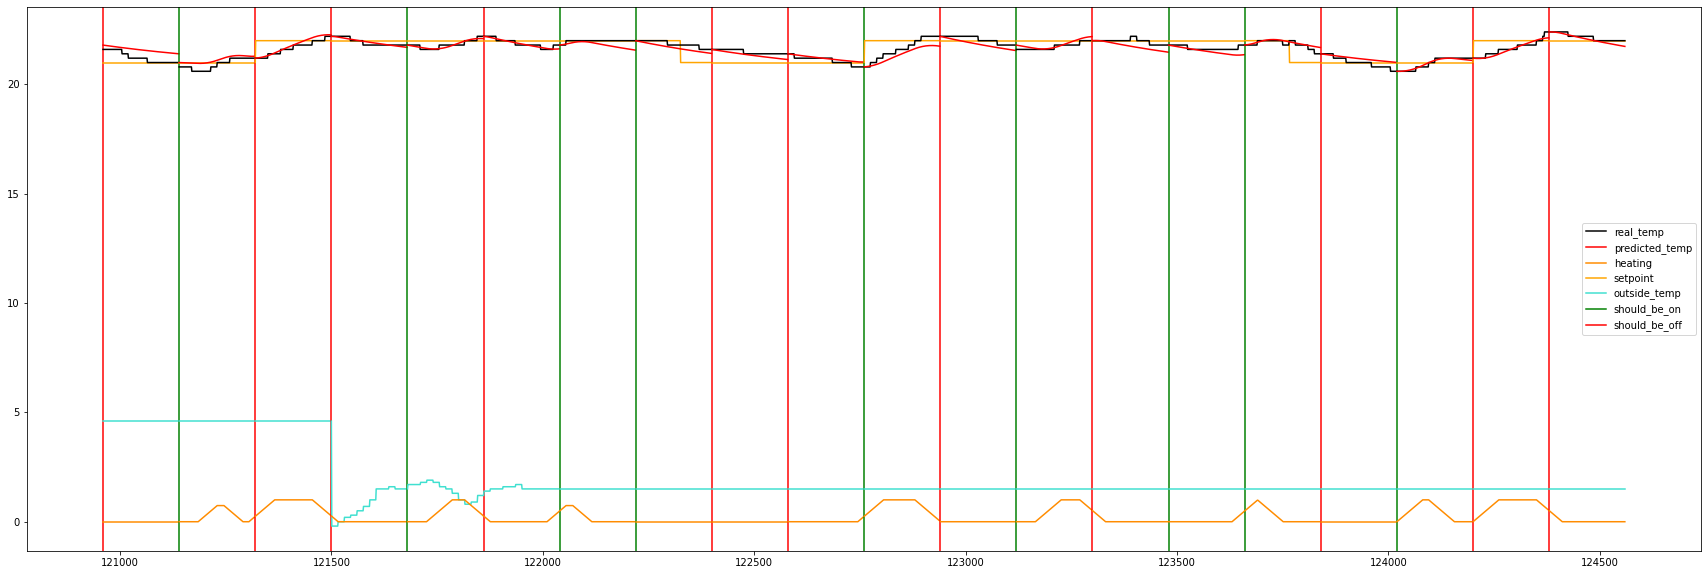

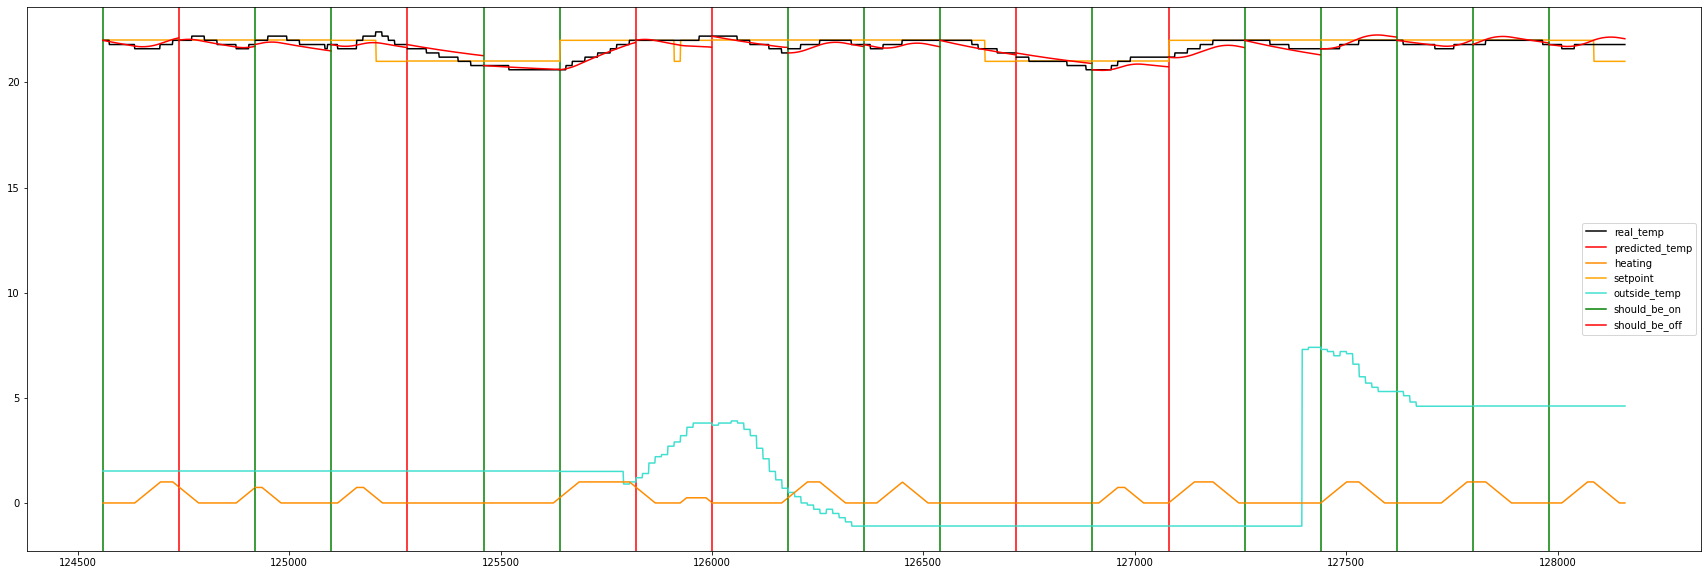

In [35]:
plot(model, add_heating=True, iterations=40)

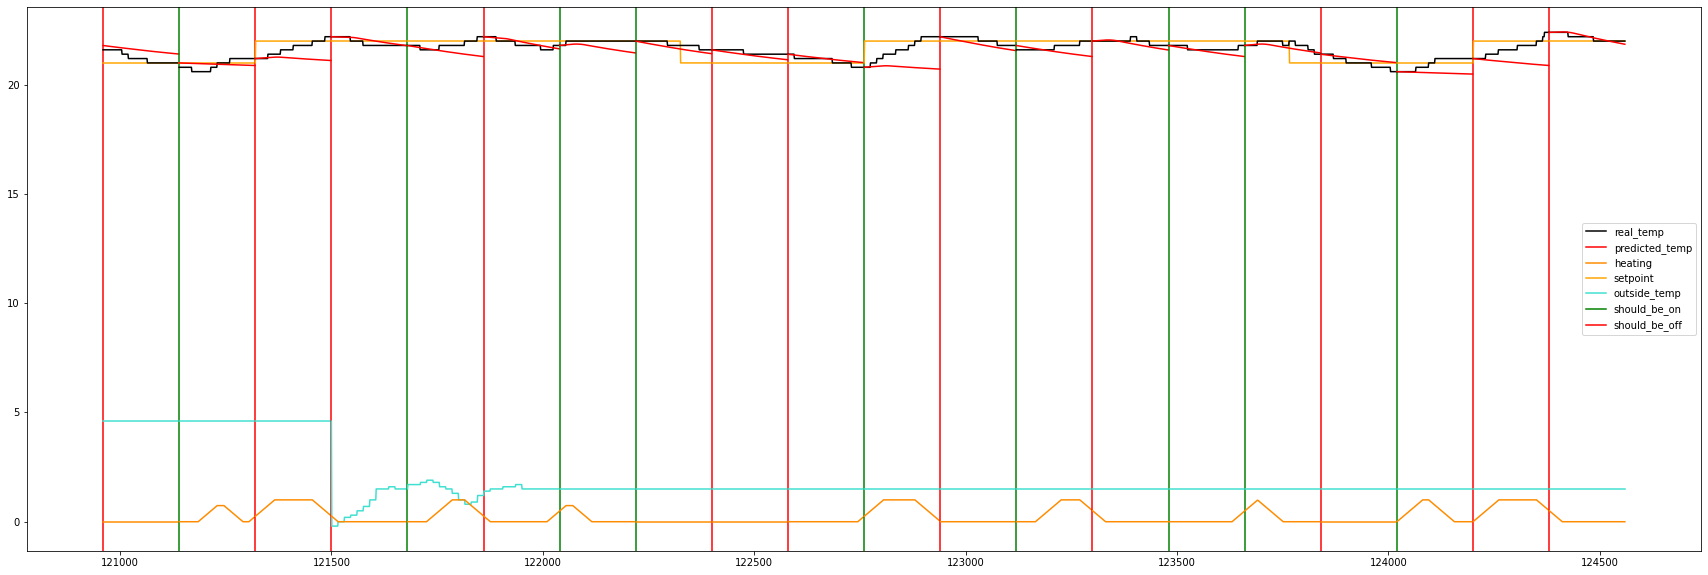

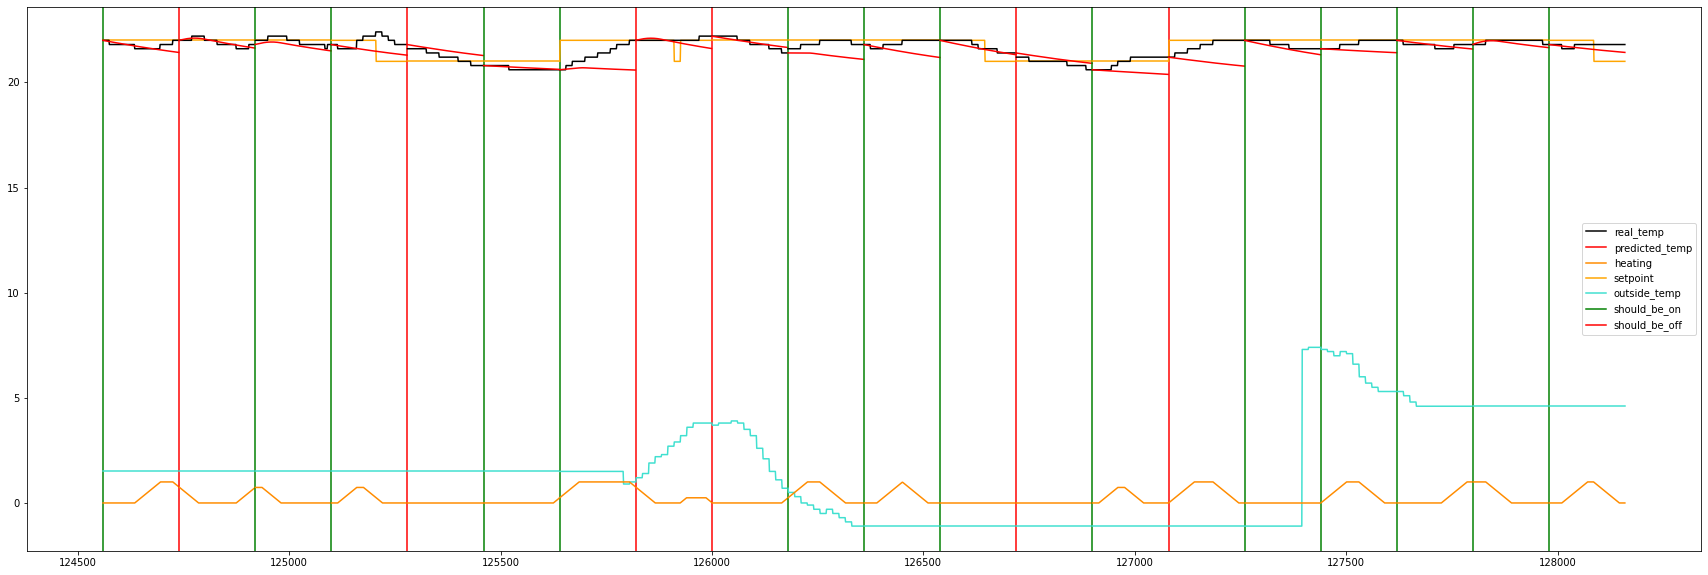

In [36]:
plot(model, add_heating=False, iterations=40)

In [37]:
def calculate_target_values_for_classification_model(model: RegressionModel, X: pd.DataFrame) -> pd.Series:
    X = X.copy()
    def _work(model, queue, X, i):
        def f(x):
            df = pd.DataFrame(columns=x.index.tolist()).append(x)
            return model.should_be_turned_off(df)
        y = X.apply(f, axis=1)
        queue.put((i, y))
    
    queue = Queue()
    row_per_iter = X.count().values[0] // cpu_count()
    processes = [Process(target=_work, args=(model, queue, X.iloc[i * row_per_iter: (i + 1) * row_per_iter], i)) for i in range(0, cpu_count() - 1)]
    processes.append(Process(target=_work, args=(model, queue, X.iloc[row_per_iter * (cpu_count() - 1):], cpu_count())))

    [p.start() for p in processes]
    [p.join() for p in processes]
    frames = sorted([queue.get() for p in processes], key=lambda x: x[0])
    frames = [f[1] for f in frames]

    y = frames[0]
    for frame in frames[1:]:
        y = y.append(frame)
    return y
on_off = calculate_target_values_for_classification_model(model, den.asfreq("15min", method="backfill").reset_index()).astype(int)

In [38]:
on_off.describe()

count    11136.000000
mean         0.432471
std          0.495441
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
dtype: float64

In [39]:
def find_best_threshold(model, X_test: pd.DataFrame, y_test: pd.DataFrame, score_func) -> tuple:
    best = [0, 0]
    predicted = model.predict_proba(X_test)
    for i in range(0, 101):
        threshold = i / 100
        score = score_func(y_test, (predicted >= threshold).astype(int)[:, 1])
        if score >= best[1]:
            best = [threshold, score]
    return tuple(best)

In [40]:
def create_classificator(X: pd.DataFrame, y: pd.DataFrame):
    model = LogisticRegression(C=30)
    X = X.copy()
    y = y.copy().astype(int)

    idx = int(X.count().values[0] * 0.8)

    X_train, X_test = X.iloc[:idx], X.iloc[idx:]
    y_train, y_test = y.iloc[:idx], y.iloc[idx:]

    normalizer = Normalizer(X_train)
    model.fit(normalizer(X_train), y_train)

    X_test_normalized = normalizer(X_test)

    f1 = find_best_threshold(model, X_test_normalized, y_test, f1_score)
    acc = find_best_threshold(model, X_test_normalized, y_test, accuracy_score)

    print(f"f1:  {f1[1]}")
    print(f"acc: {acc[1]}")

    print_sorted_coefs(model.coef_[0], X_train)

    plot_roc_curve(model, X_test_normalized, y_test)

f1:  0.966576332429991
acc: 0.9833931777378815
('Setpoint_Gabinet', -169.75337540233787)
('Temperatura_Gabinet', 38.34983583762415)
('Grzejnik_Gabinet_hourly_sum', 3.6430655645097)
('TemperaturaZewnetrzna', 2.7084222252080683)
('time', -0.5005991986941303)
('EGardenCzujnikDeszczu', 0.16229857366026312)


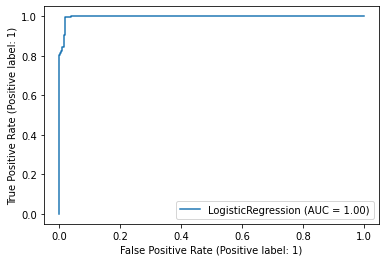

In [41]:
create_classificator(den.asfreq("15min", method="backfill").reset_index(), on_off)

In [42]:
def end():
    finish_time =  time.time() - kernel_start
    hours = int(finish_time / 3600)
    minutes = int(finish_time / 60) % 60
    seconds = int(finish_time) % 60
    print(f"Finished in: {hours:02}:{minutes:02}:{seconds:02}")
end()

Finished in: 00:25:01
